

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## Configuration


In [1]:
%%bash
 
# pip install -U ipyparams 
#pip install -U tensorflow_hub 
#pip install -U ipython
# pip install -U pymysql pyodbc
# pip install -U fasttext
# pip install -U seaborn

In [2]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from PIL import Image 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# set gpu memory
qtf.utils.set_gpu_memory_growth()

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.10) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
%reload_ext autoreload

### Initial Parameters

In [4]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

notebook_name_params = qbz95.utils.get_notebook_name().split('.')[0].split('_')
train_image_count =  int(notebook_name_params[3])
use_data_augmentation = True if len(notebook_name_params)>=5 and notebook_name_params[4]=='aug' else False

params = {
    'data_name': data_name,
    'data_path': data_path,
    'train_image_count':train_image_count,
    'use_data_augmentation': use_data_augmentation,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(train_image_count*len(classes)/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },    
    'pretrained_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': False,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': False,
            'schedule': lr_schedule,            
        }             
    },
    'fine_tune_callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': False,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        }            
    },    
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':90},
        'lenet':{'dropout':0.2, 'epochs':90},
        'custom':{'dropout':0.2, 'epochs':90},
        'vgg':{'dropout':0.1, 'epochs':90},
        'resnet':{'dropout':0.2, 'epochs':90},
        'pretrained':{'dropout':0.2, 'epochs':20, 'learning_rate':0.0001}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
model_results.clear()

2022-08-18 19:44:42,304: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json


In [5]:
params.use_data_augmentation

False

## Get Data

### Download Data 

In [6]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# train_images = train_images/255.0   
# test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)


In [7]:
if params.train_image_count*len(classes)<len(train_images):
    _, train_images, _, train_labels = train_test_split(train_images, train_labels, test_size=params.train_image_count*10, random_state=42)

    print(train_images.shape, train_labels.shape)
    print(test_images.shape, test_labels.shape)

(20000, 32, 32, 3) (20000,)
(10000, 32, 32, 3) (10000,)


In [8]:
i = 0
image_folder_path = os.path.join(params.data_path, 'data', f'image_{params.train_image_count}')
if not os.path.exists(image_folder_path):
    os.makedirs(image_folder_path)
for train_image, train_label  in zip(train_images, train_labels):
    i = i + 1
    image = Image.fromarray(train_image)
    image_path = os.path.join(image_folder_path, f"{i}.png")
    image.save(image_path)  

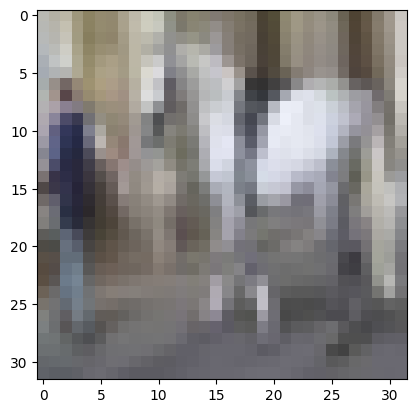

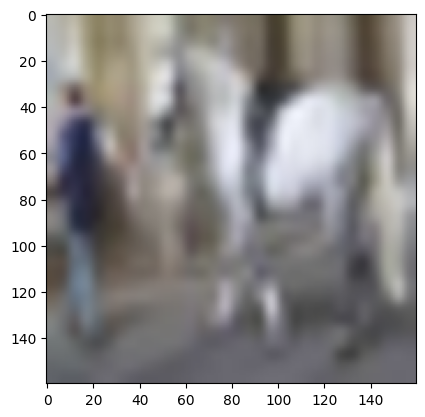

(32, 32, 3) (160, 160, 3)


In [9]:
def resize_image(image, shape=None):
    img = Image.fromarray(image)
    if shape is not None:
        img = img.resize(shape)
    image1 = np.asarray(img)
    return image1

def resize_images(images, shape=None):
    images1 = [resize_image(image, shape) for image in images]
    images1 = np.array(images1)
    return images1

input_shape=(160, 160) 
images = train_images[0:10]
images1 = resize_images(images, input_shape)

image_array = images[0]
plt.imshow(image_array)
plt.show()
 
image_array1 = images1[0]
plt.imshow(image_array1)
plt.show()

print(image_array.shape, image_array1.shape) 
# np.testing.assert_array_almost_equal(image_array, image_array1)

In [10]:
# train_images = resize_images(train_images, input_shape)
# test_images = resize_images(test_images, input_shape)

# print(train_images.shape, type(train_images), train_images.dtype)
# print(test_images.shape, type(test_images), test_images.dtype) 



### Data Explore 

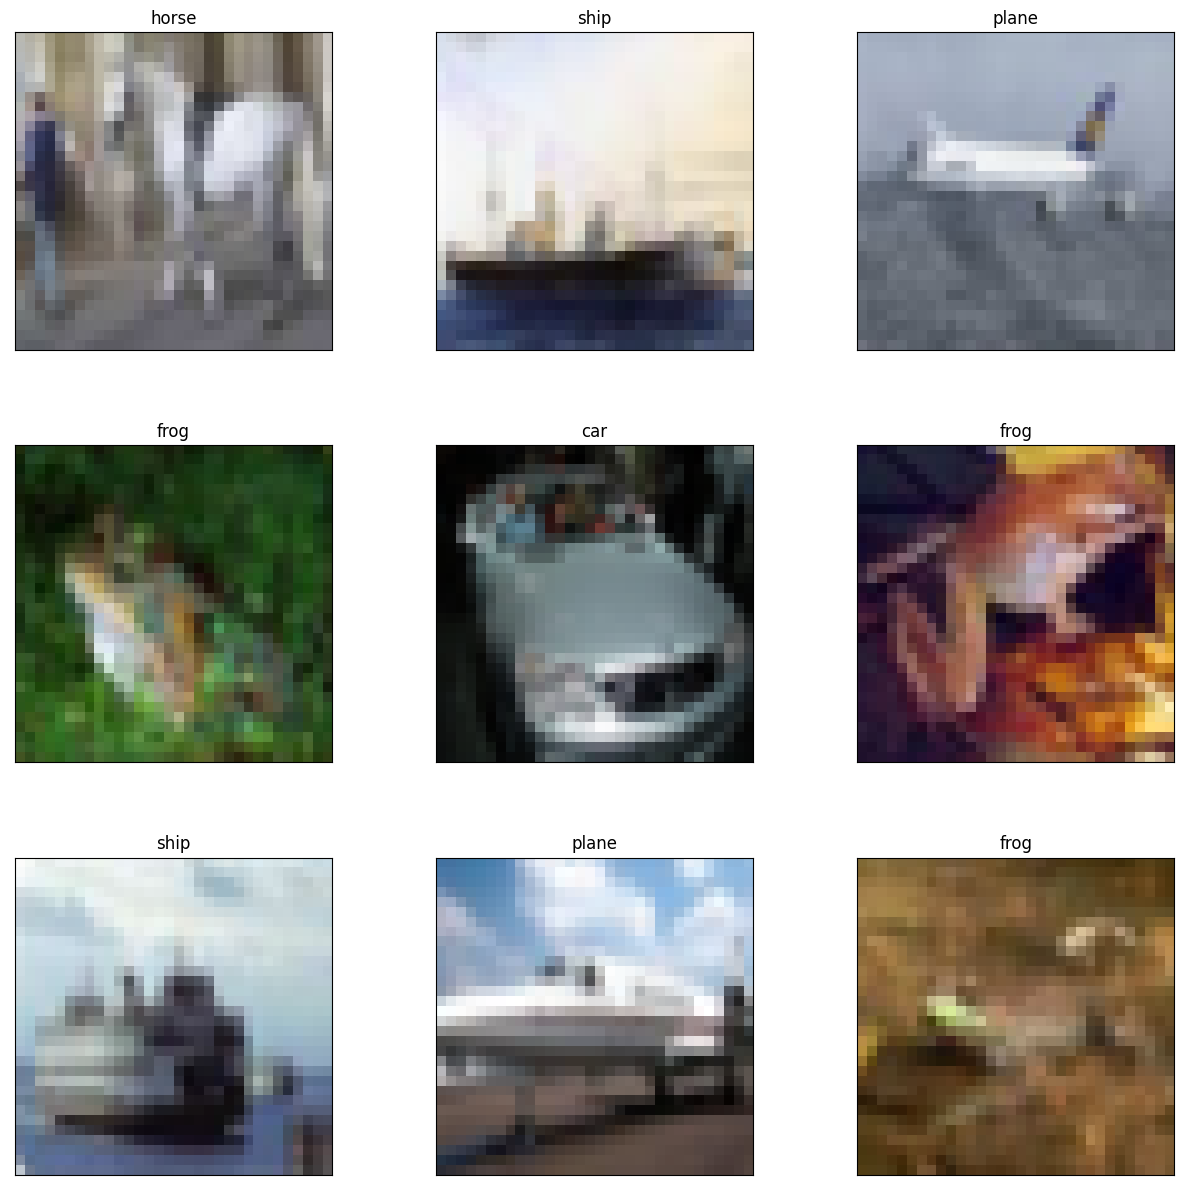

In [11]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=3, figsize=(12, 12))

### Class Distribution

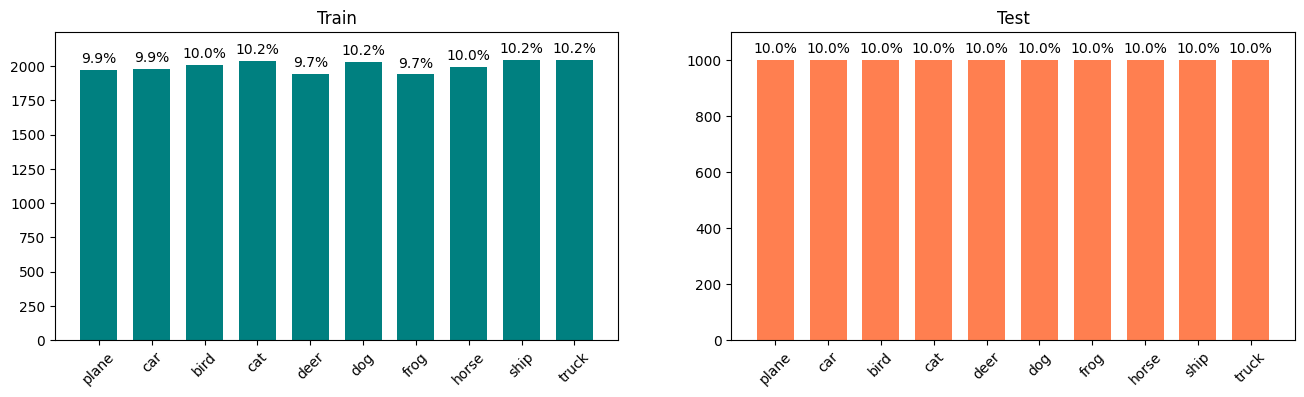

In [12]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## Prepare Data


### Raw Data


In [13]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [14]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [15]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

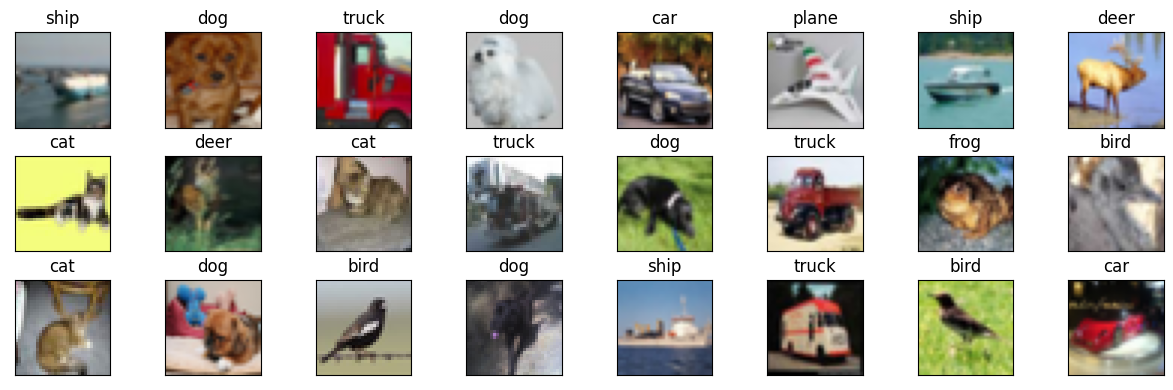

In [16]:
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### Data Augmentation

In [17]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

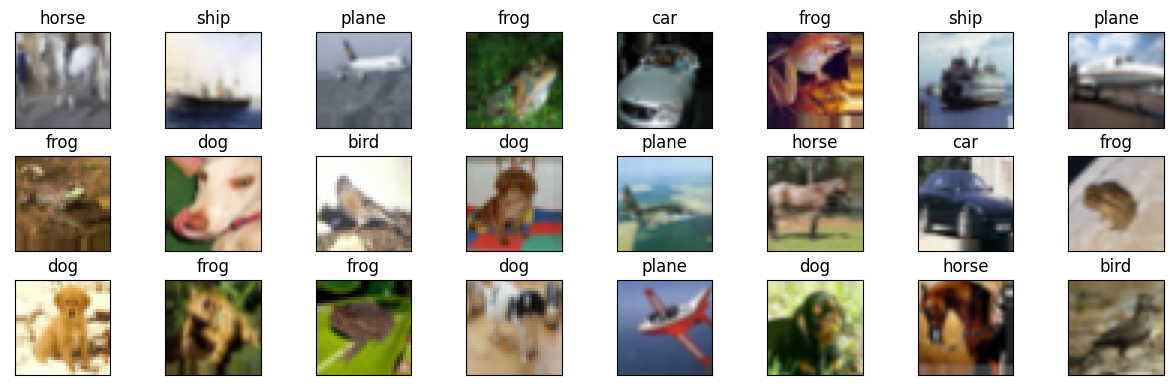

In [18]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

see orgin images

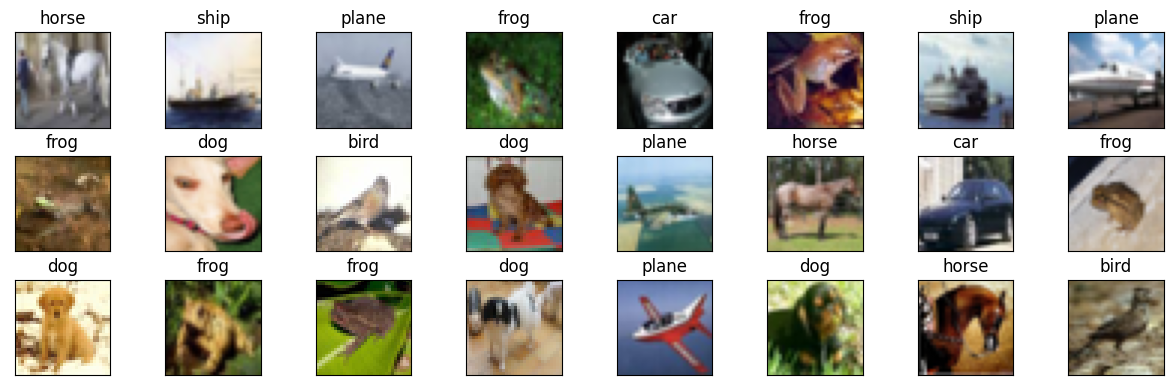

In [19]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

create data augment dataset

In [20]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [21]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


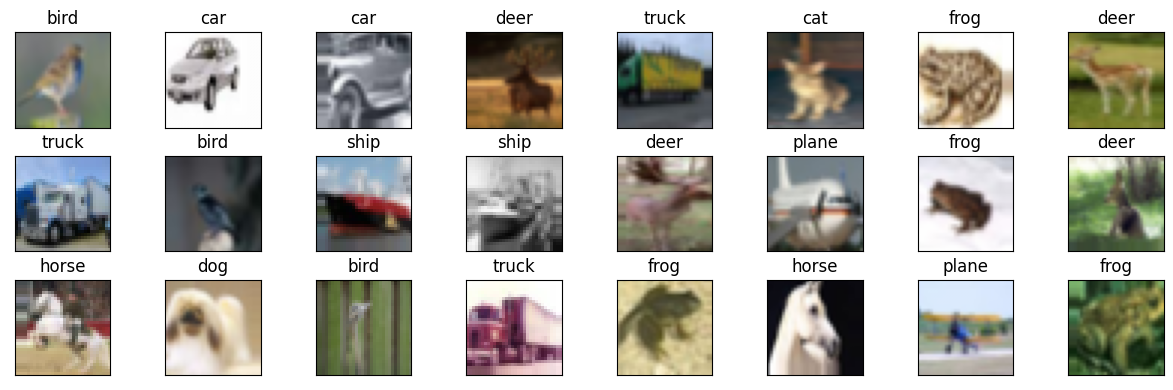

In [22]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  Models



In [22]:
rescale = tf.keras.layers.Rescaling(1./255.0, offset=0)

### MLP

2022-08-16 09:56:51,063: INFO: model_params.mlp1.dropout=0.1
2022-08-16 09:56:51,064: INFO: model_params.mlp1.layer_count=1
2022-08-16 09:56:51,065: INFO: model_params.mlp1.units=128
2022-08-16 09:56:51,106: INFO: learning_rate=0.001
2022-08-16 09:56:51,107: INFO: model_params.mlp1.clip_value=None
2022-08-16 09:56:51,116: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1


Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable 

2022-08-16 09:56:51,129: INFO: model_params.mlp1.epochs=90
2022-08-16 09:56:51,130: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1, monitor=val_accuracy)
2022-08-16 09:56:51,130: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 09:56:51,131: INFO: use LearningRateScheduler()
2022-08-16 09:56:51,132: INFO: steps_per_epoch=625
2022-08-16 09:56:51,132: INFO: start training
2022-08-16 09:56:51,133: INFO: use_class_weight=False


Epoch 1/90
608/625 [============================>.] - ETA: 0s - loss: 2.0464 - accuracy: 0.2460INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:56:55,107: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 4s 5ms/step - loss: 2.0448 - accuracy: 0.2465 - val_loss: 1.9094 - val_accuracy: 0.3071 - lr: 0.0010
Epoch 2/90
621/625 [============================>.] - ETA: 0s - loss: 1.9019 - accuracy: 0.3019INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:56:58,287: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.9022 - accuracy: 0.3016 - val_loss: 1.8335 - val_accuracy: 0.3432 - lr: 0.0010
Epoch 3/90
625/625 [==============================] - 2s 3ms/step - loss: 1.8596 - accuracy: 0.3191 - val_loss: 1.8093 - val_accuracy: 0.3425 - lr: 0.0010
Epoch 4/90
615/625 [============================>.] - ETA: 0s - loss: 1.8360 - accuracy: 0.3262INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:57:03,208: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.8362 - accuracy: 0.3266 - val_loss: 1.8072 - val_accuracy: 0.3442 - lr: 0.0010
Epoch 5/90
616/625 [============================>.] - ETA: 0s - loss: 1.8187 - accuracy: 0.3390INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:57:05,709: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 2s 4ms/step - loss: 1.8197 - accuracy: 0.3382 - val_loss: 1.7875 - val_accuracy: 0.3530 - lr: 0.0010
Epoch 6/90
625/625 [==============================] - 2s 4ms/step - loss: 1.8008 - accuracy: 0.3438 - val_loss: 1.7880 - val_accuracy: 0.3500 - lr: 0.0010
Epoch 7/90
621/625 [============================>.] - ETA: 0s - loss: 1.7889 - accuracy: 0.3496INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:57:10,769: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.7896 - accuracy: 0.3494 - val_loss: 1.7635 - val_accuracy: 0.3641 - lr: 0.0010
Epoch 8/90
621/625 [============================>.] - ETA: 0s - loss: 1.7782 - accuracy: 0.3470INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:57:13,892: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.7795 - accuracy: 0.3464 - val_loss: 1.7554 - val_accuracy: 0.3678 - lr: 0.0010
Epoch 9/90
622/625 [============================>.] - ETA: 0s - loss: 1.7688 - accuracy: 0.3540INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:57:16,613: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.7692 - accuracy: 0.3537 - val_loss: 1.7477 - val_accuracy: 0.3721 - lr: 0.0010
Epoch 10/90
621/625 [============================>.] - ETA: 0s - loss: 1.7609 - accuracy: 0.3597INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:57:19,756: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.7618 - accuracy: 0.3591 - val_loss: 1.7249 - val_accuracy: 0.3781 - lr: 0.0010
Epoch 11/90
625/625 [==============================] - 2s 3ms/step - loss: 1.7583 - accuracy: 0.3646 - val_loss: 1.7532 - val_accuracy: 0.3721 - lr: 0.0010
Epoch 12/90
618/625 [============================>.] - ETA: 0s - loss: 1.7431 - accuracy: 0.3695INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:57:24,740: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.7438 - accuracy: 0.3690 - val_loss: 1.7258 - val_accuracy: 0.3860 - lr: 0.0010
Epoch 13/90
625/625 [==============================] - 2s 3ms/step - loss: 1.7346 - accuracy: 0.3731 - val_loss: 1.7345 - val_accuracy: 0.3859 - lr: 0.0010
Epoch 14/90
625/625 [==============================] - 3s 4ms/step - loss: 1.7412 - accuracy: 0.3692 - val_loss: 1.7203 - val_accuracy: 0.3834 - lr: 0.0010
Epoch 15/90
625/625 [==============================] - 2s 3ms/step - loss: 1.7334 - accuracy: 0.3713 - val_loss: 1.7334 - val_accuracy: 0.3805 - lr: 0.0010
Epoch 16/90
625/625 [==============================] - 2s 3ms/step - loss: 1.7269 - accuracy: 0.3773 - val_loss: 1.7401 - val_accuracy: 0.3758 - lr: 0.0010
Epoch 17/90
625/625 [==============================] - 2s 4ms/step - loss: 1.7261 - accuracy: 0.3755 - val_loss: 1.7209 - val_accuracy: 0.3860 - lr: 0.0010
Epoch 18/90
625/625 [==============================] - 2s 3ms/step - loss: 1

2022-08-16 09:57:44,041: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.7093 - accuracy: 0.3823 - val_loss: 1.7130 - val_accuracy: 0.3876 - lr: 0.0010
Epoch 22/90
604/625 [===========================>..] - ETA: 0s - loss: 1.7058 - accuracy: 0.3844INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:57:46,891: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.7079 - accuracy: 0.3832 - val_loss: 1.7100 - val_accuracy: 0.3881 - lr: 0.0010
Epoch 23/90
625/625 [==============================] - 2s 3ms/step - loss: 1.7048 - accuracy: 0.3864 - val_loss: 1.7225 - val_accuracy: 0.3821 - lr: 0.0010
Epoch 24/90
625/625 [==============================] - 3s 4ms/step - loss: 1.7004 - accuracy: 0.3869 - val_loss: 1.7227 - val_accuracy: 0.3840 - lr: 0.0010
Epoch 25/90
625/625 [==============================] - 2s 3ms/step - loss: 1.6915 - accuracy: 0.3918 - val_loss: 1.7092 - val_accuracy: 0.3850 - lr: 0.0010
Epoch 26/90
625/625 [==============================] - 3s 5ms/step - loss: 1.6879 - accuracy: 0.3930 - val_loss: 1.7208 - val_accuracy: 0.3858 - lr: 0.0010
Epoch 27/90
625/625 [==============================] - 3s 5ms/step - loss: 1.6955 - accuracy: 0.3882 - val_loss: 1.7434 - val_accuracy: 0.3804 - lr: 0.0010
Epoch 28/90
625/625 [==============================] - 3s 5ms/step - loss: 1

2022-08-16 09:58:17,275: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 4s 7ms/step - loss: 1.6796 - accuracy: 0.3954 - val_loss: 1.7185 - val_accuracy: 0.3888 - lr: 0.0010
Epoch 33/90
625/625 [==============================] - 2s 3ms/step - loss: 1.6760 - accuracy: 0.3968 - val_loss: 1.7247 - val_accuracy: 0.3844 - lr: 0.0010
Epoch 34/90
605/625 [============================>.] - ETA: 0s - loss: 1.6736 - accuracy: 0.3960INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:58:21,970: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.6751 - accuracy: 0.3956 - val_loss: 1.7111 - val_accuracy: 0.3904 - lr: 0.0010
Epoch 35/90
625/625 [==============================] - 2s 4ms/step - loss: 1.6814 - accuracy: 0.3936 - val_loss: 1.7373 - val_accuracy: 0.3809 - lr: 0.0010
Epoch 36/90
625/625 [==============================] - 2s 3ms/step - loss: 1.6652 - accuracy: 0.4013 - val_loss: 1.7115 - val_accuracy: 0.3892 - lr: 0.0010
Epoch 37/90
625/625 [==============================] - 3s 4ms/step - loss: 1.6672 - accuracy: 0.3990 - val_loss: 1.7142 - val_accuracy: 0.3862 - lr: 0.0010
Epoch 38/90
625/625 [==============================] - 2s 3ms/step - loss: 1.6676 - accuracy: 0.3972 - val_loss: 1.7386 - val_accuracy: 0.3815 - lr: 0.0010
Epoch 39/90
625/625 [==============================] - 2s 3ms/step - loss: 1.6658 - accuracy: 0.4011 - val_loss: 1.7291 - val_accuracy: 0.3876 - lr: 0.0010
Epoch 40/90
608/625 [============================>.] - ETA: 0s - loss: 1.656

2022-08-16 09:58:37,706: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.6365 - accuracy: 0.4072 - val_loss: 1.6818 - val_accuracy: 0.4016 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
625/625 [==============================] - 3s 4ms/step - loss: 1.6327 - accuracy: 0.4153 - val_loss: 1.6828 - val_accuracy: 0.3996 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/90
619/625 [============================>.] - ETA: 0s - loss: 1.6233 - accuracy: 0.4159INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:58:43,146: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.6241 - accuracy: 0.4158 - val_loss: 1.6812 - val_accuracy: 0.4020 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/90
625/625 [==============================] - 2s 4ms/step - loss: 1.6283 - accuracy: 0.4112 - val_loss: 1.6874 - val_accuracy: 0.3996 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/90
625/625 [==============================] - 2s 3ms/step - loss: 1.6287 - accuracy: 0.4153 - val_loss: 1.6861 - val_accuracy: 0.4007 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/90
625/625 [==============================] - 3s 4ms/step - loss: 1.6236 - accuracy: 0.4142 - val_loss: 1.6867 - val_accuracy: 0.3991 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/90
625/625 [==============================] - 2s 3ms/step - loss: 1.6221 - accuracy: 0.4152 - val_loss:

2022-08-16 09:58:58,981: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.6191 - accuracy: 0.4164 - val_loss: 1.6838 - val_accuracy: 0.4027 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/90
625/625 [==============================] - 3s 5ms/step - loss: 1.6167 - accuracy: 0.4159 - val_loss: 1.6857 - val_accuracy: 0.4003 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/90
625/625 [==============================] - 3s 5ms/step - loss: 1.6154 - accuracy: 0.4187 - val_loss: 1.6936 - val_accuracy: 0.3978 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/90
608/625 [============================>.] - ETA: 0s - loss: 1.6164 - accuracy: 0.4190INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:59:09,003: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.6188 - accuracy: 0.4184 - val_loss: 1.6834 - val_accuracy: 0.4032 - lr: 3.1623e-04
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
Epoch 54/90
614/625 [============================>.] - ETA: 0s - loss: 1.6135 - accuracy: 0.4197INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:59:11,740: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.6154 - accuracy: 0.4193 - val_loss: 1.6811 - val_accuracy: 0.4042 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/90
625/625 [==============================] - 3s 5ms/step - loss: 1.6159 - accuracy: 0.4191 - val_loss: 1.6911 - val_accuracy: 0.4011 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/90
625/625 [==============================] - 3s 5ms/step - loss: 1.6130 - accuracy: 0.4194 - val_loss: 1.6856 - val_accuracy: 0.4007 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/90
625/625 [==============================] - 3s 6ms/step - loss: 1.6142 - accuracy: 0.4218 - val_loss: 1.6961 - val_accuracy: 0.3974 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/90
620/625 [============================>.] - ETA: 0s - loss: 1.6119 - accuracy: 0.4227
Epoch 58: Reduc

2022-08-16 09:59:29,729: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 4s 7ms/step - loss: 1.6009 - accuracy: 0.4223 - val_loss: 1.6757 - val_accuracy: 0.4056 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/90
611/625 [============================>.] - ETA: 0s - loss: 1.5976 - accuracy: 0.4257INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:59:32,358: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.5997 - accuracy: 0.4254 - val_loss: 1.6745 - val_accuracy: 0.4070 - lr: 1.0000e-04
Epoch 61/90
625/625 [==============================] - 3s 4ms/step - loss: 1.5934 - accuracy: 0.4283 - val_loss: 1.6743 - val_accuracy: 0.4070 - lr: 1.0000e-04
Epoch 62/90
625/625 [==============================] - 2s 4ms/step - loss: 1.6051 - accuracy: 0.4227 - val_loss: 1.6745 - val_accuracy: 0.4058 - lr: 1.0000e-04
Epoch 63/90
614/625 [============================>.] - ETA: 0s - loss: 1.5903 - accuracy: 0.4268INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:59:40,178: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.5919 - accuracy: 0.4265 - val_loss: 1.6762 - val_accuracy: 0.4071 - lr: 1.0000e-04
Epoch 64/90
609/625 [============================>.] - ETA: 0s - loss: 1.5940 - accuracy: 0.4285INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:59:42,805: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.5962 - accuracy: 0.4277 - val_loss: 1.6751 - val_accuracy: 0.4080 - lr: 1.0000e-04
Epoch 65/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5926 - accuracy: 0.4263 - val_loss: 1.6787 - val_accuracy: 0.4052 - lr: 1.0000e-04
Epoch 66/90
622/625 [============================>.] - ETA: 0s - loss: 1.5999 - accuracy: 0.4222INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 09:59:47,794: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.6001 - accuracy: 0.4219 - val_loss: 1.6749 - val_accuracy: 0.4088 - lr: 1.0000e-04
Epoch 67/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5932 - accuracy: 0.4261 - val_loss: 1.6802 - val_accuracy: 0.4031 - lr: 1.0000e-04
Epoch 68/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5886 - accuracy: 0.4288 - val_loss: 1.6772 - val_accuracy: 0.4054 - lr: 1.0000e-04
Epoch 69/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5985 - accuracy: 0.4263 - val_loss: 1.6755 - val_accuracy: 0.4073 - lr: 1.0000e-04
Epoch 70/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5939 - accuracy: 0.4265 - val_loss: 1.6772 - val_accuracy: 0.4071 - lr: 1.0000e-04
Epoch 71/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5921 - accuracy: 0.4271 - val_loss: 1.6788 - val_accuracy: 0.4038 - lr: 1.0000e-04
Epoch 72/90
625/625 [==============================]

2022-08-16 10:00:10,133: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.5908 - accuracy: 0.4256 - val_loss: 1.6753 - val_accuracy: 0.4091 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/90
613/625 [============================>.] - ETA: 0s - loss: 1.5825 - accuracy: 0.4303INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 10:00:12,734: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.5847 - accuracy: 0.4299 - val_loss: 1.6745 - val_accuracy: 0.4100 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5874 - accuracy: 0.4301 - val_loss: 1.6749 - val_accuracy: 0.4090 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5833 - accuracy: 0.4270 - val_loss: 1.6753 - val_accuracy: 0.4083 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/90
604/625 [===========================>..] - ETA: 0s - loss: 1.5820 - accuracy: 0.4286INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 10:00:19,552: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.5841 - accuracy: 0.4277 - val_loss: 1.6742 - val_accuracy: 0.4107 - lr: 3.1623e-05
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 82/90
614/625 [============================>.] - ETA: 0s - loss: 1.5802 - accuracy: 0.4313INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 10:00:22,237: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.5822 - accuracy: 0.4304 - val_loss: 1.6739 - val_accuracy: 0.4114 - lr: 3.1623e-05
Epoch 00083: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 83/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5911 - accuracy: 0.4265 - val_loss: 1.6753 - val_accuracy: 0.4102 - lr: 3.1623e-05
Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 84/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5843 - accuracy: 0.4304 - val_loss: 1.6749 - val_accuracy: 0.4104 - lr: 3.1623e-05
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/90
619/625 [============================>.] - ETA: 0s - loss: 1.5824 - accuracy: 0.4285INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 10:00:28,811: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 4ms/step - loss: 1.5838 - accuracy: 0.4281 - val_loss: 1.6744 - val_accuracy: 0.4115 - lr: 3.1623e-05
Epoch 00086: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 86/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5815 - accuracy: 0.4305 - val_loss: 1.6744 - val_accuracy: 0.4104 - lr: 3.1623e-05
Epoch 00087: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 87/90
610/625 [============================>.] - ETA: 0s - loss: 1.5835 - accuracy: 0.4314INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


2022-08-16 10:00:33,861: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1/assets


625/625 [==============================] - 3s 5ms/step - loss: 1.5852 - accuracy: 0.4305 - val_loss: 1.6743 - val_accuracy: 0.4116 - lr: 3.1623e-05
Epoch 00088: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 88/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5871 - accuracy: 0.4288 - val_loss: 1.6749 - val_accuracy: 0.4105 - lr: 3.1623e-05
Epoch 00089: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 89/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5890 - accuracy: 0.4277 - val_loss: 1.6745 - val_accuracy: 0.4114 - lr: 3.1623e-05
Epoch 00090: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 90/90
625/625 [==============================] - 2s 3ms/step - loss: 1.5845 - accuracy: 0.4274 - val_loss: 1.6755 - val_accuracy: 0.4094 - lr: 3.1623e-05


2022-08-16 10:00:39,832: INFO: finish training [elapsed time: 228.70 seconds]


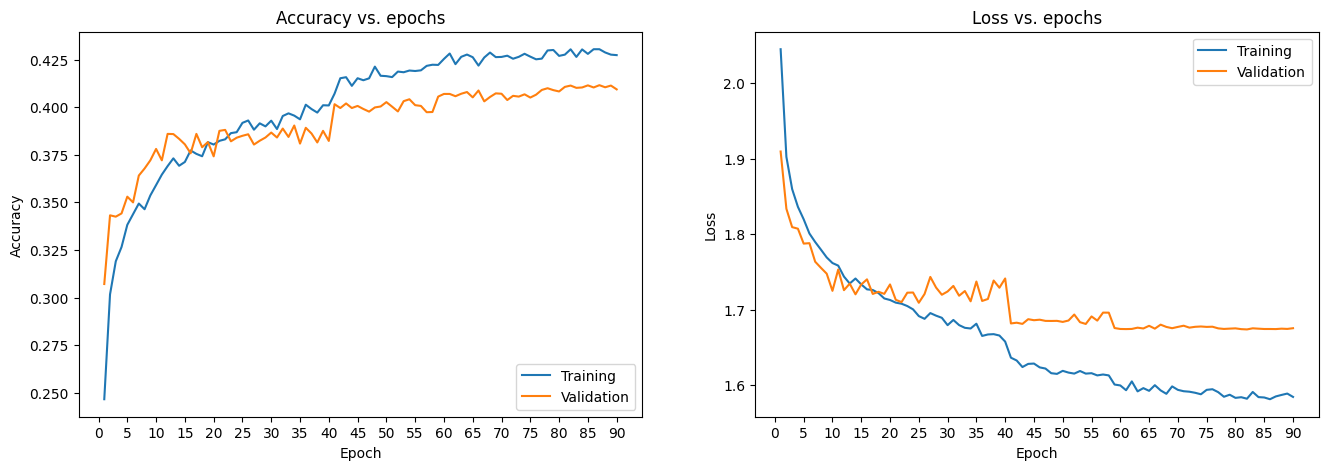

2022-08-16 10:00:40,279: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 0s 1ms/step


2022-08-16 10:00:45,588: INFO: test loss:1.6743
2022-08-16 10:00:45,589: INFO: test accuracy:0.4116
2022-08-16 10:00:45,590: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 10:00:45,592: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 10:00:45,593: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 10:00:45,594: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------
313/313 [==============================] - 0s 1ms/step


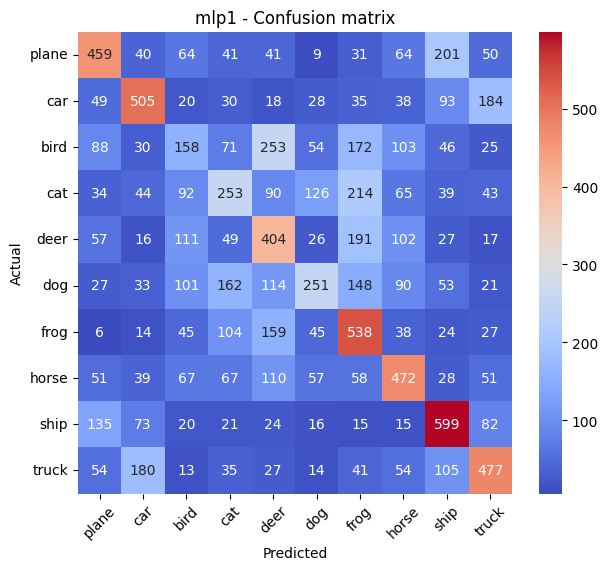

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       mlp1  cifar10_0816_cnt_2000.ipynb         394634       228.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 10:00      1.4991     1.6743          0.4681         0.4116   

   train_auc  test_auc  
1     0.8672    0.8291

In [23]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 




### LeNet

![image-20201019113632136](images/image-20201019113632136.png)


2022-08-16 10:00:47,307: INFO: model_params.lenet1.dropout=0.2
2022-08-16 10:00:47,407: INFO: learning_rate=0.001
2022-08-16 10:00:47,408: INFO: model_params.lenet1.clip_value=None
2022-08-16 10:00:47,414: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1


Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0    

2022-08-16 10:00:47,442: INFO: model_params.lenet1.epochs=90
2022-08-16 10:00:47,442: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1, monitor=val_accuracy)
2022-08-16 10:00:47,443: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 10:00:47,444: INFO: use LearningRateScheduler()
2022-08-16 10:00:47,444: INFO: steps_per_epoch=625
2022-08-16 10:00:47,445: INFO: start training
2022-08-16 10:00:47,445: INFO: use_class_weight=False


Epoch 1/90
619/625 [============================>.] - ETA: 0s - loss: 1.9046 - accuracy: 0.3035

2022-08-16 10:00:54,114: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:00:54,739: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 7s 9ms/step - loss: 1.9031 - accuracy: 0.3038 - val_loss: 1.7921 - val_accuracy: 0.3374 - lr: 0.0010
Epoch 2/90
624/625 [============================>.] - ETA: 0s - loss: 1.6202 - accuracy: 0.4053

2022-08-16 10:00:59,506: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:01:00,129: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 5s 9ms/step - loss: 1.6205 - accuracy: 0.4052 - val_loss: 1.4832 - val_accuracy: 0.4643 - lr: 0.0010
Epoch 3/90
625/625 [==============================] - 3s 5ms/step - loss: 1.4866 - accuracy: 0.4631 - val_loss: 1.6113 - val_accuracy: 0.4359 - lr: 0.0010
Epoch 4/90
625/625 [==============================] - 3s 5ms/step - loss: 1.3858 - accuracy: 0.5082 - val_loss: 1.6606 - val_accuracy: 0.4456 - lr: 0.0010
Epoch 5/90
618/625 [============================>.] - ETA: 0s - loss: 1.3189 - accuracy: 0.5280

2022-08-16 10:01:11,642: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:01:12,269: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 5s 9ms/step - loss: 1.3208 - accuracy: 0.5275 - val_loss: 1.4253 - val_accuracy: 0.4959 - lr: 0.0010
Epoch 6/90
625/625 [==============================] - ETA: 0s - loss: 1.2762 - accuracy: 0.5427

2022-08-16 10:01:17,455: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:01:18,080: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 6s 9ms/step - loss: 1.2762 - accuracy: 0.5427 - val_loss: 1.3295 - val_accuracy: 0.5263 - lr: 0.0010
Epoch 7/90
620/625 [============================>.] - ETA: 0s - loss: 1.2278 - accuracy: 0.5607

2022-08-16 10:01:22,759: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:01:23,603: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 6s 9ms/step - loss: 1.2281 - accuracy: 0.5602 - val_loss: 1.1585 - val_accuracy: 0.5824 - lr: 0.0010
Epoch 8/90
625/625 [==============================] - 3s 5ms/step - loss: 1.1919 - accuracy: 0.5770 - val_loss: 2.2262 - val_accuracy: 0.3617 - lr: 0.0010
Epoch 9/90
625/625 [==============================] - ETA: 0s - loss: 1.1539 - accuracy: 0.5889

2022-08-16 10:01:31,782: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:01:32,467: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 6s 9ms/step - loss: 1.1539 - accuracy: 0.5889 - val_loss: 1.1292 - val_accuracy: 0.5981 - lr: 0.0010
Epoch 10/90
619/625 [============================>.] - ETA: 0s - loss: 1.1190 - accuracy: 0.5993

2022-08-16 10:01:37,651: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:01:38,278: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 6s 9ms/step - loss: 1.1196 - accuracy: 0.5989 - val_loss: 1.1158 - val_accuracy: 0.6001 - lr: 0.0010
Epoch 11/90
619/625 [============================>.] - ETA: 0s - loss: 1.1128 - accuracy: 0.6023

2022-08-16 10:01:43,109: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:01:44,000: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 6s 9ms/step - loss: 1.1123 - accuracy: 0.6026 - val_loss: 1.0998 - val_accuracy: 0.6038 - lr: 0.0010
Epoch 12/90
625/625 [==============================] - 3s 5ms/step - loss: 1.0820 - accuracy: 0.6108 - val_loss: 1.1919 - val_accuracy: 0.5805 - lr: 0.0010
Epoch 13/90
625/625 [==============================] - 4s 6ms/step - loss: 1.0625 - accuracy: 0.6222 - val_loss: 1.1545 - val_accuracy: 0.5886 - lr: 0.0010
Epoch 14/90
625/625 [==============================] - 3s 5ms/step - loss: 1.0443 - accuracy: 0.6296 - val_loss: 1.5544 - val_accuracy: 0.4895 - lr: 0.0010
Epoch 15/90
625/625 [==============================] - 3s 5ms/step - loss: 1.0319 - accuracy: 0.6278 - val_loss: 1.5543 - val_accuracy: 0.4885 - lr: 0.0010
Epoch 16/90
625/625 [==============================] - 3s 5ms/step - loss: 1.0117 - accuracy: 0.6407 - val_loss: 1.5932 - val_accuracy: 0.4905 - lr: 0.0010
Epoch 17/90
625/625 [==============================] - 4s 6ms/step - loss: 0

2022-08-16 10:02:26,184: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:02:26,811: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 5s 8ms/step - loss: 0.9188 - accuracy: 0.6709 - val_loss: 1.0766 - val_accuracy: 0.6244 - lr: 0.0010
Epoch 24/90
625/625 [==============================] - 4s 6ms/step - loss: 0.9147 - accuracy: 0.6701 - val_loss: 1.3092 - val_accuracy: 0.5726 - lr: 0.0010
Epoch 25/90
625/625 [==============================] - 3s 5ms/step - loss: 0.9018 - accuracy: 0.6791 - val_loss: 1.2023 - val_accuracy: 0.6036 - lr: 0.0010
Epoch 26/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8894 - accuracy: 0.6793 - val_loss: 1.2019 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 27/90
617/625 [============================>.] - ETA: 0s - loss: 0.8759 - accuracy: 0.6879

2022-08-16 10:02:41,826: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:02:42,562: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 5s 9ms/step - loss: 0.8759 - accuracy: 0.6880 - val_loss: 1.0930 - val_accuracy: 0.6281 - lr: 0.0010
Epoch 28/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8800 - accuracy: 0.6822 - val_loss: 1.2141 - val_accuracy: 0.5952 - lr: 0.0010
Epoch 29/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8711 - accuracy: 0.6872 - val_loss: 1.5016 - val_accuracy: 0.5387 - lr: 0.0010
Epoch 30/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8621 - accuracy: 0.6899 - val_loss: 1.1410 - val_accuracy: 0.6109 - lr: 0.0010
Epoch 31/90
621/625 [============================>.] - ETA: 0s - loss: 0.8558 - accuracy: 0.6951

2022-08-16 10:02:57,686: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:02:58,309: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 6s 9ms/step - loss: 0.8559 - accuracy: 0.6953 - val_loss: 1.0193 - val_accuracy: 0.6503 - lr: 0.0010
Epoch 32/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8486 - accuracy: 0.6969 - val_loss: 1.4249 - val_accuracy: 0.5753 - lr: 0.0010
Epoch 33/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8490 - accuracy: 0.6963 - val_loss: 1.0876 - val_accuracy: 0.6316 - lr: 0.0010
Epoch 34/90
625/625 [==============================] - 4s 6ms/step - loss: 0.8328 - accuracy: 0.7019 - val_loss: 1.1652 - val_accuracy: 0.6140 - lr: 0.0010
Epoch 35/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8298 - accuracy: 0.6992 - val_loss: 1.0877 - val_accuracy: 0.6273 - lr: 0.0010
Epoch 36/90
625/625 [==============================] - 3s 5ms/step - loss: 0.8146 - accuracy: 0.7078 - val_loss: 1.3150 - val_accuracy: 0.5760 - lr: 0.0010
Epoch 37/90
625/625 [==============================] - 3s 5ms/step - loss: 0

2022-08-16 10:03:40,787: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:03:41,409: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 6s 9ms/step - loss: 0.7861 - accuracy: 0.7182 - val_loss: 1.0355 - val_accuracy: 0.6563 - lr: 0.0010
Epoch 44/90
625/625 [==============================] - 3s 5ms/step - loss: 0.7886 - accuracy: 0.7181 - val_loss: 1.1253 - val_accuracy: 0.6157 - lr: 0.0010
Epoch 45/90
625/625 [==============================] - 4s 6ms/step - loss: 0.7733 - accuracy: 0.7239 - val_loss: 1.5904 - val_accuracy: 0.5343 - lr: 0.0010
Epoch 46/90
620/625 [============================>.] - ETA: 0s - loss: 0.7831 - accuracy: 0.7210
Epoch 46: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
625/625 [==============================] - 3s 5ms/step - loss: 0.7839 - accuracy: 0.7207 - val_loss: 1.1454 - val_accuracy: 0.6154 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/90
625/625 [==============================] - 3s 5ms/step - loss: 0.7262 - accuracy: 0.7405 - val_loss: 1.1028 - val_accuracy: 0.6352 - lr: 3.1623e

2022-08-16 10:04:10,199: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:04:10,823: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 5s 9ms/step - loss: 0.7106 - accuracy: 0.7437 - val_loss: 0.9866 - val_accuracy: 0.6671 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/90
625/625 [==============================] - 4s 6ms/step - loss: 0.6970 - accuracy: 0.7508 - val_loss: 1.0981 - val_accuracy: 0.6431 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/90
625/625 [==============================] - 3s 5ms/step - loss: 0.6938 - accuracy: 0.7502 - val_loss: 1.1060 - val_accuracy: 0.6439 - lr: 3.1623e-04
Epoch 00054: Still keep learning rate 0.0003162 instead of 0.001
Epoch 54/90
625/625 [==============================] - 3s 5ms/step - loss: 0.6897 - accuracy: 0.7506 - val_loss: 1.0217 - val_accuracy: 0.6600 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/90
625/625 [==============================] - 3s 5ms/step - loss: 0.7033 - accuracy: 0.7469 - val_loss:

2022-08-16 10:04:46,650: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:04:47,304: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 6s 9ms/step - loss: 0.6655 - accuracy: 0.7627 - val_loss: 0.9865 - val_accuracy: 0.6723 - lr: 1.0000e-04
Epoch 62/90
625/625 [==============================] - 3s 5ms/step - loss: 0.6582 - accuracy: 0.7628 - val_loss: 0.9967 - val_accuracy: 0.6677 - lr: 1.0000e-04
Epoch 63/90
625/625 [==============================] - 3s 6ms/step - loss: 0.6630 - accuracy: 0.7610 - val_loss: 1.0076 - val_accuracy: 0.6666 - lr: 1.0000e-04
Epoch 64/90
625/625 [==============================] - 3s 5ms/step - loss: 0.6634 - accuracy: 0.7616 - val_loss: 1.0090 - val_accuracy: 0.6639 - lr: 1.0000e-04
Epoch 65/90
625/625 [==============================] - 3s 5ms/step - loss: 0.6520 - accuracy: 0.7622 - val_loss: 1.0122 - val_accuracy: 0.6670 - lr: 1.0000e-04
Epoch 66/90
625/625 [==============================] - 3s 5ms/step - loss: 0.6483 - accuracy: 0.7691 - val_loss: 1.0075 - val_accuracy: 0.6657 - lr: 1.0000e-04
Epoch 67/90
625/625 [==============================]

2022-08-16 10:05:37,132: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


2022-08-16 10:05:37,743: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1/assets


625/625 [==============================] - 6s 9ms/step - loss: 0.6515 - accuracy: 0.7682 - val_loss: 0.9998 - val_accuracy: 0.6736 - lr: 1.0000e-04
Epoch 76/90
623/625 [============================>.] - ETA: 0s - loss: 0.6484 - accuracy: 0.7677
Epoch 76: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
625/625 [==============================] - 3s 5ms/step - loss: 0.6485 - accuracy: 0.7677 - val_loss: 1.0034 - val_accuracy: 0.6660 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/90
625/625 [==============================] - 3s 5ms/step - loss: 0.6540 - accuracy: 0.7667 - val_loss: 1.0045 - val_accuracy: 0.6708 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/90
625/625 [==============================] - 4s 6ms/step - loss: 0.6436 - accuracy: 0.7719 - val_loss: 1.0112 - val_accuracy: 0.6666 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 79/90
62

2022-08-16 10:06:31,158: INFO: finish training [elapsed time: 343.71 seconds]


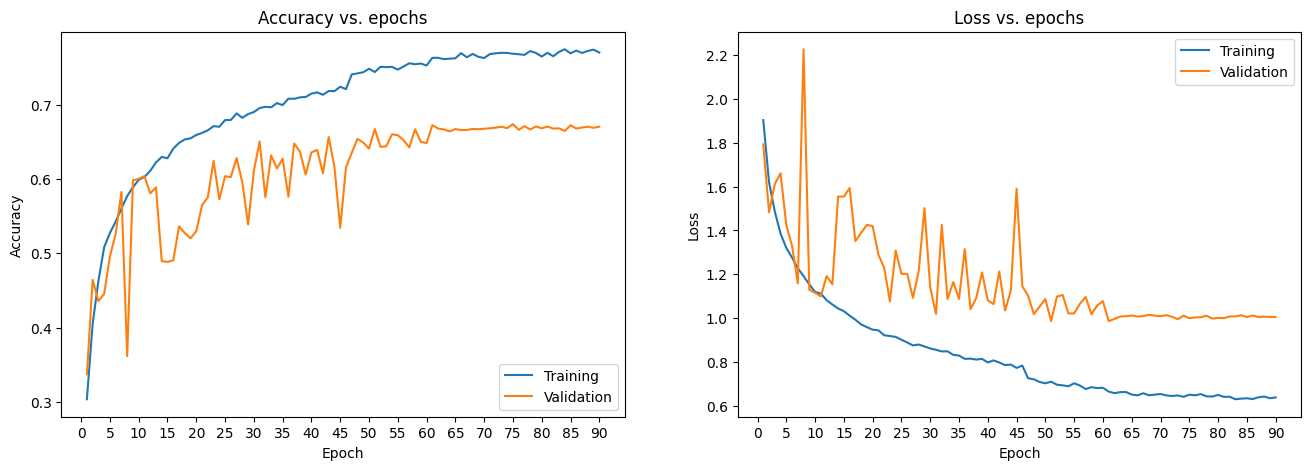

2022-08-16 10:06:31,587: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 2ms/step


2022-08-16 10:06:39,061: INFO: test loss:0.9998
2022-08-16 10:06:39,061: INFO: test accuracy:0.6736
2022-08-16 10:06:39,063: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 10:06:39,065: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 10:06:39,066: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 10:06:39,067: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 10:06:39,068: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/mlp1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 10:06:39,413: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator


313/313 [==============================] - 0s 1ms/step


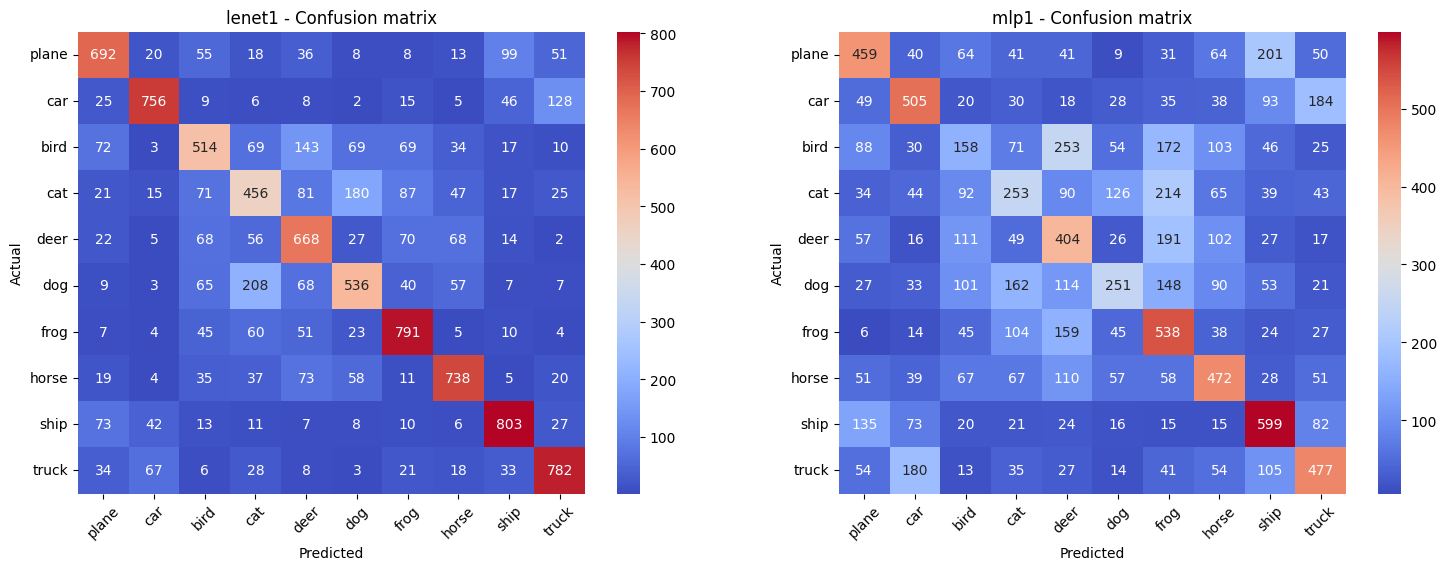

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1     lenet1  cifar10_0816_cnt_2000.ipynb          83170       343.7   
2       mlp1  cifar10_0816_cnt_2000.ipynb         394634       228.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 10:06      0.3276     0.9998          0.8982         0.6736   
2  2022-08-16 10:00      1.4991     1.6743          0.4681         0.4116   

   train_auc  test_auc  
1     0.9944    0.9460  
2     0.8672    0.8291

In [24]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Custom 1


2022-08-16 10:06:43,004: INFO: model_params.custom1.dropout=0.2
2022-08-16 10:06:43,114: INFO: learning_rate=0.001
2022-08-16 10:06:43,115: INFO: model_params.custom1.clip_value=None
2022-08-16 10:06:43,122: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1


Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0   

2022-08-16 10:06:43,153: INFO: model_params.custom1.epochs=90
2022-08-16 10:06:43,154: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1, monitor=val_accuracy)
2022-08-16 10:06:43,155: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 10:06:43,155: INFO: use LearningRateScheduler()
2022-08-16 10:06:43,156: INFO: steps_per_epoch=625
2022-08-16 10:06:43,156: INFO: start training
2022-08-16 10:06:43,157: INFO: use_class_weight=False


Epoch 1/90
615/625 [============================>.] - ETA: 0s - loss: 1.8491 - accuracy: 0.3367

2022-08-16 10:06:49,906: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:06:50,591: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 7s 10ms/step - loss: 1.8455 - accuracy: 0.3381 - val_loss: 1.5700 - val_accuracy: 0.4267 - lr: 0.0010
Epoch 2/90
622/625 [============================>.] - ETA: 0s - loss: 1.5044 - accuracy: 0.4580

2022-08-16 10:06:56,339: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:06:57,008: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 1.5040 - accuracy: 0.4582 - val_loss: 1.4297 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 3/90
621/625 [============================>.] - ETA: 0s - loss: 1.3613 - accuracy: 0.5097

2022-08-16 10:07:02,613: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:07:03,307: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 1.3625 - accuracy: 0.5093 - val_loss: 1.3855 - val_accuracy: 0.5069 - lr: 0.0010
Epoch 4/90
625/625 [==============================] - 4s 7ms/step - loss: 1.2690 - accuracy: 0.5444 - val_loss: 1.7598 - val_accuracy: 0.4107 - lr: 0.0010
Epoch 5/90
619/625 [============================>.] - ETA: 0s - loss: 1.1858 - accuracy: 0.5790

2022-08-16 10:07:12,981: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:07:13,677: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 1.1860 - accuracy: 0.5786 - val_loss: 1.1649 - val_accuracy: 0.5898 - lr: 0.0010
Epoch 6/90
623/625 [============================>.] - ETA: 0s - loss: 1.1312 - accuracy: 0.5964

2022-08-16 10:07:19,301: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:07:20,263: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 7s 11ms/step - loss: 1.1314 - accuracy: 0.5962 - val_loss: 1.1060 - val_accuracy: 0.6064 - lr: 0.0010
Epoch 7/90
625/625 [==============================] - 4s 6ms/step - loss: 1.0781 - accuracy: 0.6195 - val_loss: 1.1706 - val_accuracy: 0.5917 - lr: 0.0010
Epoch 8/90
621/625 [============================>.] - ETA: 0s - loss: 1.0431 - accuracy: 0.6301

2022-08-16 10:07:29,738: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:07:30,446: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 1.0444 - accuracy: 0.6298 - val_loss: 1.0826 - val_accuracy: 0.6177 - lr: 0.0010
Epoch 9/90
620/625 [============================>.] - ETA: 0s - loss: 1.0076 - accuracy: 0.6444

2022-08-16 10:07:36,141: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:07:36,844: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 1.0081 - accuracy: 0.6441 - val_loss: 1.0439 - val_accuracy: 0.6344 - lr: 0.0010
Epoch 10/90
625/625 [==============================] - 4s 6ms/step - loss: 0.9781 - accuracy: 0.6497 - val_loss: 1.2097 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 11/90
618/625 [============================>.] - ETA: 0s - loss: 0.9539 - accuracy: 0.6637

2022-08-16 10:07:46,122: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:07:47,129: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 0.9540 - accuracy: 0.6635 - val_loss: 0.9493 - val_accuracy: 0.6654 - lr: 0.0010
Epoch 12/90
625/625 [==============================] - 4s 7ms/step - loss: 0.9219 - accuracy: 0.6693 - val_loss: 1.1131 - val_accuracy: 0.6163 - lr: 0.0010
Epoch 13/90
625/625 [==============================] - 4s 6ms/step - loss: 0.9027 - accuracy: 0.6811 - val_loss: 1.3106 - val_accuracy: 0.5746 - lr: 0.0010
Epoch 14/90
625/625 [==============================] - 4s 6ms/step - loss: 0.8899 - accuracy: 0.6830 - val_loss: 1.0845 - val_accuracy: 0.6357 - lr: 0.0010
Epoch 15/90
622/625 [============================>.] - ETA: 0s - loss: 0.8615 - accuracy: 0.6988

2022-08-16 10:08:04,992: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:08:05,693: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 7s 11ms/step - loss: 0.8622 - accuracy: 0.6985 - val_loss: 0.9318 - val_accuracy: 0.6808 - lr: 0.0010
Epoch 16/90
625/625 [==============================] - 4s 6ms/step - loss: 0.8479 - accuracy: 0.6985 - val_loss: 0.9644 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 17/90
625/625 [==============================] - 4s 7ms/step - loss: 0.8282 - accuracy: 0.7054 - val_loss: 1.1048 - val_accuracy: 0.6321 - lr: 0.0010
Epoch 18/90
624/625 [============================>.] - ETA: 0s - loss: 0.8226 - accuracy: 0.7070

2022-08-16 10:08:19,516: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:08:20,214: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 0.8227 - accuracy: 0.7071 - val_loss: 0.9103 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 19/90
625/625 [==============================] - 4s 6ms/step - loss: 0.8097 - accuracy: 0.7124 - val_loss: 1.2615 - val_accuracy: 0.5866 - lr: 0.0010
Epoch 20/90
625/625 [==============================] - 4s 7ms/step - loss: 0.8004 - accuracy: 0.7162 - val_loss: 0.9299 - val_accuracy: 0.6820 - lr: 0.0010
Epoch 21/90
625/625 [==============================] - 4s 6ms/step - loss: 0.7905 - accuracy: 0.7210 - val_loss: 0.9305 - val_accuracy: 0.6807 - lr: 0.0010
Epoch 22/90
625/625 [==============================] - 4s 6ms/step - loss: 0.7715 - accuracy: 0.7259 - val_loss: 1.0684 - val_accuracy: 0.6438 - lr: 0.0010
Epoch 23/90
625/625 [==============================] - 4s 6ms/step - loss: 0.7607 - accuracy: 0.7308 - val_loss: 1.0276 - val_accuracy: 0.6585 - lr: 0.0010
Epoch 24/90
625/625 [==============================] - 4s 7ms/step - loss: 

2022-08-16 10:08:53,720: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:08:54,433: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 0.7439 - accuracy: 0.7343 - val_loss: 0.9165 - val_accuracy: 0.6909 - lr: 0.0010
Epoch 27/90
625/625 [==============================] - 4s 6ms/step - loss: 0.7277 - accuracy: 0.7420 - val_loss: 1.0109 - val_accuracy: 0.6679 - lr: 0.0010
Epoch 28/90
625/625 [==============================] - 4s 6ms/step - loss: 0.7171 - accuracy: 0.7454 - val_loss: 1.0613 - val_accuracy: 0.6502 - lr: 0.0010
Epoch 29/90
625/625 [==============================] - 4s 6ms/step - loss: 0.7197 - accuracy: 0.7403 - val_loss: 1.5596 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 30/90
625/625 [==============================] - 4s 7ms/step - loss: 0.7162 - accuracy: 0.7483 - val_loss: 1.0528 - val_accuracy: 0.6586 - lr: 0.0010
Epoch 31/90
625/625 [==============================] - 4s 6ms/step - loss: 0.6977 - accuracy: 0.7497 - val_loss: 1.3289 - val_accuracy: 0.6060 - lr: 0.0010
Epoch 32/90
625/625 [==============================] - 4s 6ms/step - loss: 

2022-08-16 10:09:33,742: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:09:34,445: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 7s 11ms/step - loss: 0.6200 - accuracy: 0.7785 - val_loss: 0.9299 - val_accuracy: 0.7032 - lr: 3.1623e-04
Epoch 00036: Still keep learning rate 0.0003162 instead of 0.001
Epoch 36/90
621/625 [============================>.] - ETA: 0s - loss: 0.6056 - accuracy: 0.7829

2022-08-16 10:09:40,242: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:09:40,937: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 0.6063 - accuracy: 0.7825 - val_loss: 0.9181 - val_accuracy: 0.7061 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/90
625/625 [==============================] - ETA: 0s - loss: 0.6010 - accuracy: 0.7886

2022-08-16 10:09:46,662: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:09:47,379: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 0.6010 - accuracy: 0.7886 - val_loss: 0.9080 - val_accuracy: 0.7140 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/90
624/625 [============================>.] - ETA: 0s - loss: 0.6003 - accuracy: 0.7866

2022-08-16 10:09:53,273: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:09:53,972: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 7s 10ms/step - loss: 0.6005 - accuracy: 0.7865 - val_loss: 0.8649 - val_accuracy: 0.7215 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/90
625/625 [==============================] - 4s 6ms/step - loss: 0.5911 - accuracy: 0.7908 - val_loss: 0.9736 - val_accuracy: 0.6939 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/90
625/625 [==============================] - ETA: 0s - loss: 0.5816 - accuracy: 0.7946

2022-08-16 10:10:03,629: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:10:04,602: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 7s 11ms/step - loss: 0.5816 - accuracy: 0.7946 - val_loss: 0.8397 - val_accuracy: 0.7303 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
625/625 [==============================] - 5s 7ms/step - loss: 0.5894 - accuracy: 0.7861 - val_loss: 0.8624 - val_accuracy: 0.7225 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
625/625 [==============================] - 4s 6ms/step - loss: 0.5805 - accuracy: 0.7915 - val_loss: 0.8961 - val_accuracy: 0.7133 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/90
625/625 [==============================] - 4s 6ms/step - loss: 0.5777 - accuracy: 0.7914 - val_loss: 0.9140 - val_accuracy: 0.7090 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/90
625/625 [==============================] - 4s 7ms/step - loss: 0.5696 - accuracy: 0.7999 - val_loss

2022-08-16 10:10:43,641: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:10:44,388: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 7s 11ms/step - loss: 0.5648 - accuracy: 0.7986 - val_loss: 0.8562 - val_accuracy: 0.7305 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/90
625/625 [==============================] - 5s 8ms/step - loss: 0.5607 - accuracy: 0.7975 - val_loss: 0.8391 - val_accuracy: 0.7296 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/90
625/625 [==============================] - 5s 8ms/step - loss: 0.5564 - accuracy: 0.8022 - val_loss: 0.9991 - val_accuracy: 0.6937 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/90
625/625 [==============================] - 5s 8ms/step - loss: 0.5596 - accuracy: 0.8006 - val_loss: 0.9637 - val_accuracy: 0.7063 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/90
625/625 [==============================] - 5s 7ms/step - loss: 0.5576 - accuracy: 0.8015 - val_loss

2022-08-16 10:11:09,548: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:11:10,242: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 7s 11ms/step - loss: 0.5550 - accuracy: 0.8005 - val_loss: 0.8150 - val_accuracy: 0.7332 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/90
625/625 [==============================] - 5s 8ms/step - loss: 0.5514 - accuracy: 0.7993 - val_loss: 0.9079 - val_accuracy: 0.7160 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/90
625/625 [==============================] - 5s 8ms/step - loss: 0.5436 - accuracy: 0.8036 - val_loss: 0.8974 - val_accuracy: 0.7189 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/90
625/625 [==============================] - 5s 8ms/step - loss: 0.5382 - accuracy: 0.8042 - val_loss: 0.8403 - val_accuracy: 0.7324 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/90
625/625 [==============================] - 5s 7ms/step - loss: 0.5429 - accuracy: 0.8046 - val_loss

2022-08-16 10:11:43,349: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:11:44,385: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 7s 11ms/step - loss: 0.5289 - accuracy: 0.8074 - val_loss: 0.8164 - val_accuracy: 0.7378 - lr: 1.0000e-04
Epoch 62/90
625/625 [==============================] - 5s 7ms/step - loss: 0.5259 - accuracy: 0.8112 - val_loss: 0.8284 - val_accuracy: 0.7352 - lr: 1.0000e-04
Epoch 63/90
625/625 [==============================] - 4s 6ms/step - loss: 0.5118 - accuracy: 0.8152 - val_loss: 0.8446 - val_accuracy: 0.7327 - lr: 1.0000e-04
Epoch 64/90
623/625 [============================>.] - ETA: 0s - loss: 0.5198 - accuracy: 0.8128

2022-08-16 10:12:00,973: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:12:01,670: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 9s 14ms/step - loss: 0.5200 - accuracy: 0.8125 - val_loss: 0.8099 - val_accuracy: 0.7415 - lr: 1.0000e-04
Epoch 65/90
625/625 [==============================] - 5s 8ms/step - loss: 0.5145 - accuracy: 0.8133 - val_loss: 0.8760 - val_accuracy: 0.7279 - lr: 1.0000e-04
Epoch 66/90
625/625 [==============================] - 10s 15ms/step - loss: 0.5089 - accuracy: 0.8163 - val_loss: 0.8228 - val_accuracy: 0.7380 - lr: 1.0000e-04
Epoch 67/90
625/625 [==============================] - 4s 6ms/step - loss: 0.5087 - accuracy: 0.8180 - val_loss: 0.8129 - val_accuracy: 0.7411 - lr: 1.0000e-04
Epoch 68/90
625/625 [==============================] - 4s 6ms/step - loss: 0.5068 - accuracy: 0.8169 - val_loss: 0.8255 - val_accuracy: 0.7380 - lr: 1.0000e-04
Epoch 69/90
615/625 [============================>.] - ETA: 0s - loss: 0.5009 - accuracy: 0.8196

2022-08-16 10:12:29,520: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:12:30,212: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 0.5020 - accuracy: 0.8190 - val_loss: 0.8167 - val_accuracy: 0.7420 - lr: 1.0000e-04
Epoch 70/90
615/625 [============================>.] - ETA: 0s - loss: 0.5013 - accuracy: 0.8202

2022-08-16 10:12:35,857: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 3 of 3). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


2022-08-16 10:12:36,588: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1/assets


625/625 [==============================] - 6s 10ms/step - loss: 0.5015 - accuracy: 0.8202 - val_loss: 0.8096 - val_accuracy: 0.7438 - lr: 1.0000e-04
Epoch 71/90
625/625 [==============================] - 7s 12ms/step - loss: 0.5099 - accuracy: 0.8158 - val_loss: 0.8543 - val_accuracy: 0.7334 - lr: 1.0000e-04
Epoch 72/90
625/625 [==============================] - 6s 9ms/step - loss: 0.5098 - accuracy: 0.8164 - val_loss: 0.8159 - val_accuracy: 0.7402 - lr: 1.0000e-04
Epoch 73/90
625/625 [==============================] - 4s 6ms/step - loss: 0.5125 - accuracy: 0.8174 - val_loss: 0.8189 - val_accuracy: 0.7407 - lr: 1.0000e-04
Epoch 74/90
625/625 [==============================] - 4s 6ms/step - loss: 0.5018 - accuracy: 0.8178 - val_loss: 0.8133 - val_accuracy: 0.7428 - lr: 1.0000e-04
Epoch 75/90
625/625 [==============================] - 4s 6ms/step - loss: 0.5037 - accuracy: 0.8191 - val_loss: 0.8282 - val_accuracy: 0.7392 - lr: 1.0000e-04
Epoch 76/90
625/625 [=============================

2022-08-16 10:14:10,468: INFO: finish training [elapsed time: 447.31 seconds]


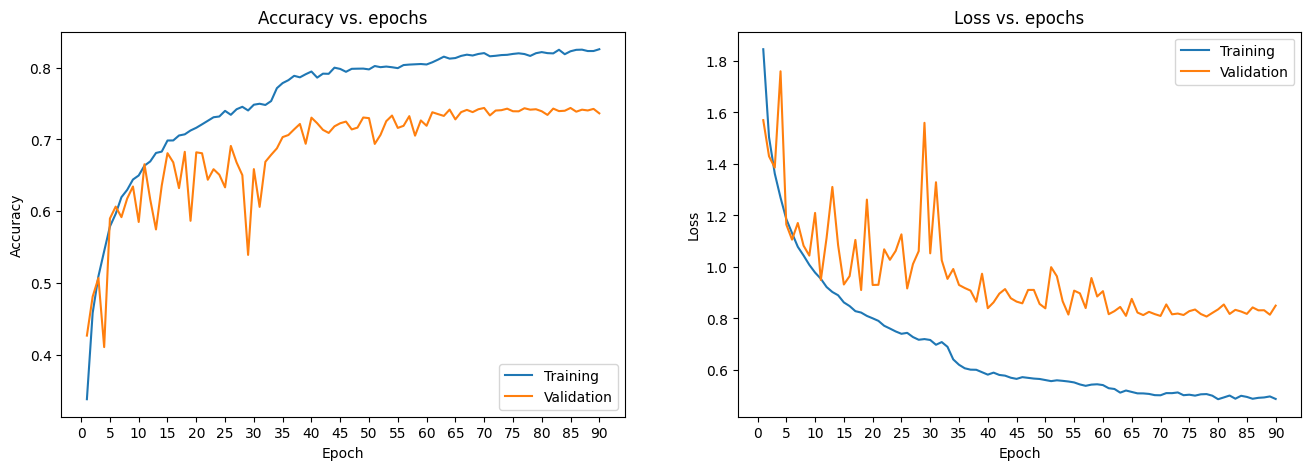

2022-08-16 10:14:10,942: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-16 10:14:21,836: INFO: test loss:0.8096
2022-08-16 10:14:21,837: INFO: test accuracy:0.7438
2022-08-16 10:14:21,838: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 10:14:21,840: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 10:14:21,840: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 10:14:21,841: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 10:14:21,842: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/lenet1


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 10:14:22,749: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator


313/313 [==============================] - 1s 2ms/step


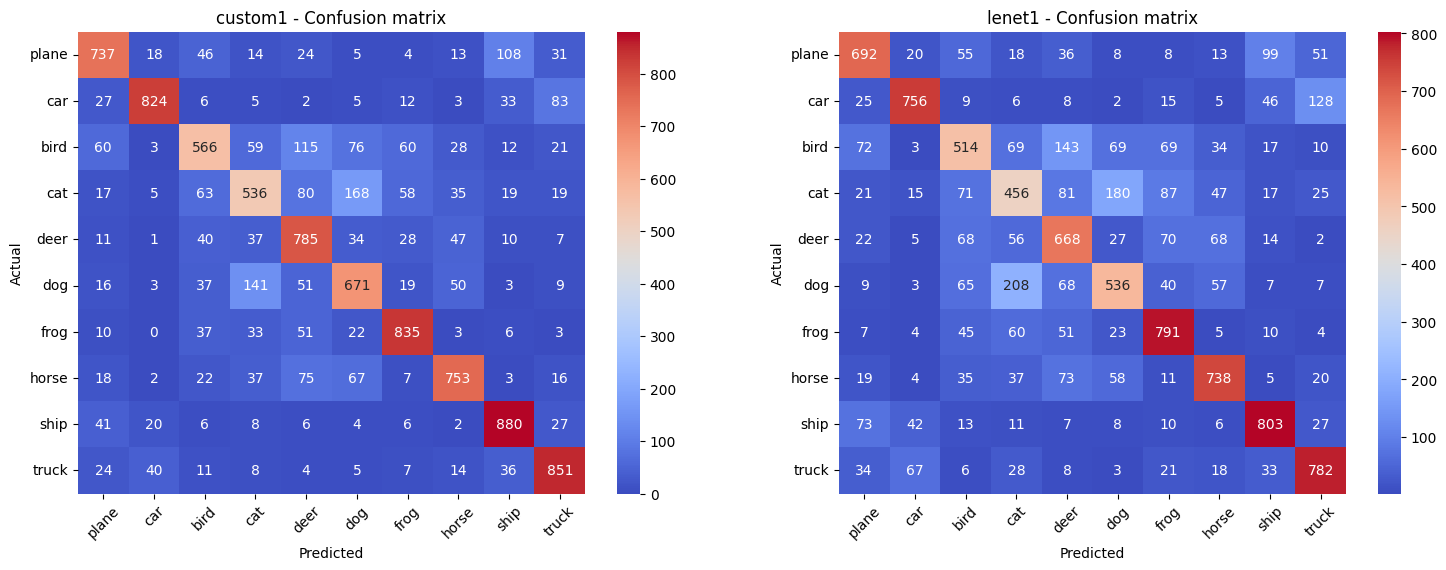

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1    custom1  cifar10_0816_cnt_2000.ipynb          73738       447.3   
2     lenet1  cifar10_0816_cnt_2000.ipynb          83170       343.7   
3       mlp1  cifar10_0816_cnt_2000.ipynb         394634       228.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 10:14      0.2368     0.8096          0.9258         0.7438   
2  2022-08-16 10:06      0.3276     0.9998          0.8982         0.6736   
3  2022-08-16 10:00      1.4991     1.6743          0.4681         0.4116   

   train_auc  test_auc  
1     0.9967    0.9651  
2     0.9944    0.9460  
3     0.8672    0.8291

In [25]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1', preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### VGG

In [26]:
rescale1 = tf.keras.layers.Rescaling(1./255.0)
for data, label in datasets.train_dataset.take(1):
    print(data[0][0][0:5]) 
    print(rescale(data)[0][0][0:5])  

tf.Tensor(
[[152 159 150]
 [155 182 204]
 [170 206 246]
 [151 185 212]
 [160 181 199]], shape=(5, 3), dtype=uint8)
tf.Tensor(
[[0.59607846 0.62352943 0.5882353 ]
 [0.60784316 0.7137255  0.8000001 ]
 [0.6666667  0.8078432  0.96470594]
 [0.5921569  0.7254902  0.8313726 ]
 [0.627451   0.70980394 0.7803922 ]], shape=(5, 3), dtype=float32)


In [27]:

helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3, 
                                             preprocess_fun=rescale)
model.summary()


2022-08-16 10:14:26,553: INFO: model_params.vgg8.dropout=0.1
2022-08-16 10:14:26,734: INFO: learning_rate=0.001
2022-08-16 10:14:26,735: INFO: model_params.vgg8.clip_value=None
2022-08-16 10:14:26,741: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                              

2022-08-16 10:14:26,889: INFO: model_params.vgg8.epochs=90
2022-08-16 10:14:26,890: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8, monitor=val_accuracy)
2022-08-16 10:14:26,891: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 10:14:26,892: INFO: use LearningRateScheduler()
2022-08-16 10:14:26,892: INFO: steps_per_epoch=625
2022-08-16 10:14:26,893: INFO: start training
2022-08-16 10:14:26,894: INFO: use_class_weight=False


Epoch 1/90
621/625 [============================>.] - ETA: 0s - loss: 1.7720 - accuracy: 0.3579

2022-08-16 10:14:39,787: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:14:40,937: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 14s 20ms/step - loss: 1.7713 - accuracy: 0.3582 - val_loss: 1.5699 - val_accuracy: 0.4282 - lr: 0.0010
Epoch 2/90
625/625 [==============================] - ETA: 0s - loss: 1.3512 - accuracy: 0.5076

2022-08-16 10:14:57,991: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:14:59,148: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 18s 29ms/step - loss: 1.3512 - accuracy: 0.5076 - val_loss: 1.2823 - val_accuracy: 0.5405 - lr: 0.0010
Epoch 3/90
621/625 [============================>.] - ETA: 0s - loss: 1.1309 - accuracy: 0.5924

2022-08-16 10:15:10,106: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:15:11,248: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 12s 19ms/step - loss: 1.1313 - accuracy: 0.5924 - val_loss: 1.2179 - val_accuracy: 0.5685 - lr: 0.0010
Epoch 4/90
625/625 [==============================] - 10s 15ms/step - loss: 0.9955 - accuracy: 0.6417 - val_loss: 1.2838 - val_accuracy: 0.5422 - lr: 0.0010
Epoch 5/90
624/625 [============================>.] - ETA: 0s - loss: 0.8831 - accuracy: 0.6830

2022-08-16 10:15:36,933: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:15:38,086: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 17s 27ms/step - loss: 0.8838 - accuracy: 0.6828 - val_loss: 0.9927 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 6/90
625/625 [==============================] - 8s 13ms/step - loss: 0.8047 - accuracy: 0.7117 - val_loss: 1.1947 - val_accuracy: 0.6048 - lr: 0.0010
Epoch 7/90
625/625 [==============================] - 13s 22ms/step - loss: 0.7220 - accuracy: 0.7394 - val_loss: 1.1413 - val_accuracy: 0.6228 - lr: 0.0010
Epoch 8/90
622/625 [============================>.] - ETA: 0s - loss: 0.6536 - accuracy: 0.7656

2022-08-16 10:16:12,188: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:16:13,319: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 13s 21ms/step - loss: 0.6541 - accuracy: 0.7655 - val_loss: 0.8789 - val_accuracy: 0.7122 - lr: 0.0010
Epoch 9/90
625/625 [==============================] - 8s 13ms/step - loss: 0.5848 - accuracy: 0.7898 - val_loss: 1.1060 - val_accuracy: 0.6579 - lr: 0.0010
Epoch 10/90
625/625 [==============================] - 15s 24ms/step - loss: 0.5150 - accuracy: 0.8113 - val_loss: 0.9785 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 11/90
625/625 [==============================] - 8s 14ms/step - loss: 0.4703 - accuracy: 0.8309 - val_loss: 1.2624 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 12/90
621/625 [============================>.] - ETA: 0s - loss: 0.4118 - accuracy: 0.8472

2022-08-16 10:16:56,348: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:16:57,495: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 12s 20ms/step - loss: 0.4130 - accuracy: 0.8469 - val_loss: 0.8687 - val_accuracy: 0.7411 - lr: 0.0010
Epoch 13/90
625/625 [==============================] - 15s 24ms/step - loss: 0.3919 - accuracy: 0.8574 - val_loss: 0.9286 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 14/90
621/625 [============================>.] - ETA: 0s - loss: 0.3537 - accuracy: 0.8745

2022-08-16 10:17:23,453: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:17:24,900: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 12s 20ms/step - loss: 0.3543 - accuracy: 0.8741 - val_loss: 0.8748 - val_accuracy: 0.7601 - lr: 0.0010
Epoch 15/90
625/625 [==============================] - 8s 14ms/step - loss: 0.3277 - accuracy: 0.8797 - val_loss: 0.9859 - val_accuracy: 0.7374 - lr: 0.0010
Epoch 16/90
625/625 [==============================] - 12s 19ms/step - loss: 0.2984 - accuracy: 0.8906 - val_loss: 0.9059 - val_accuracy: 0.7595 - lr: 0.0010
Epoch 17/90
625/625 [==============================] - 12s 19ms/step - loss: 0.2730 - accuracy: 0.9039 - val_loss: 1.2509 - val_accuracy: 0.6827 - lr: 0.0010
Epoch 18/90
625/625 [==============================] - 8s 13ms/step - loss: 0.2535 - accuracy: 0.9094 - val_loss: 1.3378 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 19/90
625/625 [==============================] - 9s 15ms/step - loss: 0.2254 - accuracy: 0.9194 - val_loss: 1.0824 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 20/90
625/625 [==============================] - 14s 23ms/ste

2022-08-16 10:18:39,700: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:18:40,845: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 12s 19ms/step - loss: 0.2050 - accuracy: 0.9279 - val_loss: 0.9504 - val_accuracy: 0.7695 - lr: 0.0010
Epoch 22/90
625/625 [==============================] - 11s 18ms/step - loss: 0.1875 - accuracy: 0.9354 - val_loss: 0.9986 - val_accuracy: 0.7668 - lr: 0.0010
Epoch 23/90
624/625 [============================>.] - ETA: 0s - loss: 0.1890 - accuracy: 0.9341

2022-08-16 10:19:06,489: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:19:08,041: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 16s 25ms/step - loss: 0.1888 - accuracy: 0.9341 - val_loss: 0.9990 - val_accuracy: 0.7768 - lr: 0.0010
Epoch 24/90
625/625 [==============================] - 8s 13ms/step - loss: 0.1796 - accuracy: 0.9356 - val_loss: 1.2955 - val_accuracy: 0.7338 - lr: 0.0010
Epoch 25/90
625/625 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9427

2022-08-16 10:19:28,773: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:19:29,920: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 14s 22ms/step - loss: 0.1604 - accuracy: 0.9427 - val_loss: 1.0624 - val_accuracy: 0.7811 - lr: 0.0010
Epoch 26/90
625/625 [==============================] - 9s 15ms/step - loss: 0.1477 - accuracy: 0.9443 - val_loss: 1.1909 - val_accuracy: 0.7566 - lr: 0.0010
Epoch 27/90
625/625 [==============================] - ETA: 0s - loss: 0.1490 - accuracy: 0.9463

2022-08-16 10:19:50,033: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:19:51,212: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets



Epoch 27: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
625/625 [==============================] - 12s 19ms/step - loss: 0.1490 - accuracy: 0.9463 - val_loss: 1.0077 - val_accuracy: 0.7855 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
624/625 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9654

2022-08-16 10:20:08,440: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:20:09,573: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 18s 29ms/step - loss: 0.0953 - accuracy: 0.9654 - val_loss: 0.9189 - val_accuracy: 0.8144 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
622/625 [============================>.] - ETA: 0s - loss: 0.0693 - accuracy: 0.9759

2022-08-16 10:20:21,067: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:20:22,220: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 13s 20ms/step - loss: 0.0696 - accuracy: 0.9759 - val_loss: 0.9625 - val_accuracy: 0.8151 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
624/625 [============================>.] - ETA: 0s - loss: 0.0667 - accuracy: 0.9768

2022-08-16 10:20:37,192: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:20:38,344: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 16s 26ms/step - loss: 0.0667 - accuracy: 0.9768 - val_loss: 0.9375 - val_accuracy: 0.8175 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/90
625/625 [==============================] - 8s 13ms/step - loss: 0.0609 - accuracy: 0.9785 - val_loss: 1.0250 - val_accuracy: 0.8117 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
625/625 [==============================] - 8s 13ms/step - loss: 0.0604 - accuracy: 0.9791 - val_loss: 1.1153 - val_accuracy: 0.8067 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
625/625 [==============================] - 12s 19ms/step - loss: 0.0524 - accuracy: 0.9812 - val_loss: 0.9791 - val_accuracy: 0.8143 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
625/625 [==============================] - 11s 17ms/step - loss: 0.0489 - accuracy: 0.9833 - v

2022-08-16 10:22:01,140: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:22:02,302: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 12s 20ms/step - loss: 0.0390 - accuracy: 0.9869 - val_loss: 1.1358 - val_accuracy: 0.8186 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/90
625/625 [==============================] - 9s 15ms/step - loss: 0.0334 - accuracy: 0.9886 - val_loss: 1.1415 - val_accuracy: 0.8171 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/90
625/625 [==============================] - 14s 22ms/step - loss: 0.0316 - accuracy: 0.9898 - val_loss: 1.1642 - val_accuracy: 0.8117 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/90
622/625 [============================>.] - ETA: 0s - loss: 0.0306 - accuracy: 0.9893

2022-08-16 10:22:36,617: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:22:37,756: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 13s 20ms/step - loss: 0.0305 - accuracy: 0.9894 - val_loss: 1.0881 - val_accuracy: 0.8211 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/90
625/625 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9895
Epoch 42: ReduceLROnPlateau reducing learning rate to 0.00010000000639606199.
625/625 [==============================] - 14s 22ms/step - loss: 0.0308 - accuracy: 0.9895 - val_loss: 1.1220 - val_accuracy: 0.8204 - lr: 1.0000e-04
Epoch 00043: Still keep learning rate 0.0001 instead of 0.001
Epoch 43/90
622/625 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9915

2022-08-16 10:23:04,172: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:23:05,276: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 13s 21ms/step - loss: 0.0257 - accuracy: 0.9915 - val_loss: 1.1125 - val_accuracy: 0.8234 - lr: 1.0000e-04
Epoch 00044: Still keep learning rate 0.0001 instead of 0.001
Epoch 44/90
625/625 [==============================] - ETA: 0s - loss: 0.0187 - accuracy: 0.9936

2022-08-16 10:23:16,419: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:23:17,931: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 13s 20ms/step - loss: 0.0187 - accuracy: 0.9936 - val_loss: 1.1564 - val_accuracy: 0.8241 - lr: 1.0000e-04
Epoch 00045: Still keep learning rate 0.0001 instead of 0.001
Epoch 45/90
625/625 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9937

2022-08-16 10:23:35,332: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:23:36,486: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 19s 30ms/step - loss: 0.0188 - accuracy: 0.9937 - val_loss: 1.1522 - val_accuracy: 0.8249 - lr: 1.0000e-04
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/90
622/625 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9925

2022-08-16 10:23:48,004: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:23:49,179: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 13s 20ms/step - loss: 0.0199 - accuracy: 0.9925 - val_loss: 1.1611 - val_accuracy: 0.8254 - lr: 1.0000e-04
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/90
621/625 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9948

2022-08-16 10:24:07,244: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:24:08,380: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 19s 31ms/step - loss: 0.0164 - accuracy: 0.9948 - val_loss: 1.1776 - val_accuracy: 0.8274 - lr: 1.0000e-04
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/90
623/625 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9947

2022-08-16 10:24:19,975: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:24:21,101: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 13s 20ms/step - loss: 0.0173 - accuracy: 0.9948 - val_loss: 1.1559 - val_accuracy: 0.8289 - lr: 1.0000e-04
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/90
625/625 [==============================] - 14s 23ms/step - loss: 0.0174 - accuracy: 0.9940 - val_loss: 1.2041 - val_accuracy: 0.8236 - lr: 1.0000e-04
Epoch 00050: Still keep learning rate 0.0001 instead of 0.001
Epoch 50/90
625/625 [==============================] - 22s 35ms/step - loss: 0.0149 - accuracy: 0.9953 - val_loss: 1.1644 - val_accuracy: 0.8284 - lr: 1.0000e-04
Epoch 00051: Still keep learning rate 0.0001 instead of 0.001
Epoch 51/90
625/625 [==============================] - 9s 14ms/step - loss: 0.0168 - accuracy: 0.9938 - val_loss: 1.2041 - val_accuracy: 0.8234 - lr: 1.0000e-04
Epoch 00052: Still keep learning rate 0.0001 instead of 0.001
Epoch 52/90
625/625 [==============================] - 9s 14ms/step - loss: 0.0157 - accuracy: 0.9951 - val_loss: 1.2

2022-08-16 10:25:51,137: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 6). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


2022-08-16 10:25:52,253: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8/assets


625/625 [==============================] - 20s 32ms/step - loss: 0.0133 - accuracy: 0.9956 - val_loss: 1.2263 - val_accuracy: 0.8299 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/90
625/625 [==============================] - 17s 27ms/step - loss: 0.0142 - accuracy: 0.9949 - val_loss: 1.2393 - val_accuracy: 0.8238 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/90
624/625 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9953
Epoch 57: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
625/625 [==============================] - 9s 14ms/step - loss: 0.0134 - accuracy: 0.9953 - val_loss: 1.2528 - val_accuracy: 0.8270 - lr: 3.1623e-05
Epoch 00058: LearningRateScheduler reducing learning rate to 0.001 from 3.16e-05.
Epoch 58/90
625/625 [==============================] - 9s 14ms/step - loss: 0.2397 - accuracy: 0.9230 - val_loss: 1.1605 - val_accuracy: 0.7776 - lr: 0.0010
E

2022-08-16 10:31:26,048: INFO: finish training [elapsed time: 1019.16 seconds]


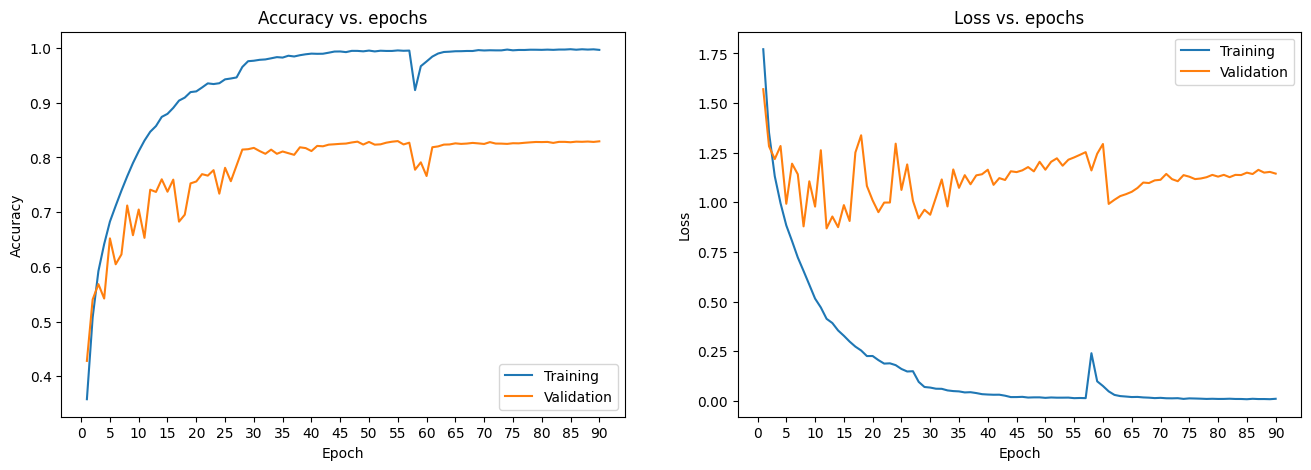

2022-08-16 10:31:26,490: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 1s 3ms/step


2022-08-16 10:31:37,451: INFO: test loss:1.2263
2022-08-16 10:31:37,452: INFO: test accuracy:0.8299
2022-08-16 10:31:37,454: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 10:31:37,456: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 10:31:37,456: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 10:31:37,457: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 10:31:37,458: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/custom1

----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 10:31:38,454: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator


313/313 [==============================] - 1s 2ms/step


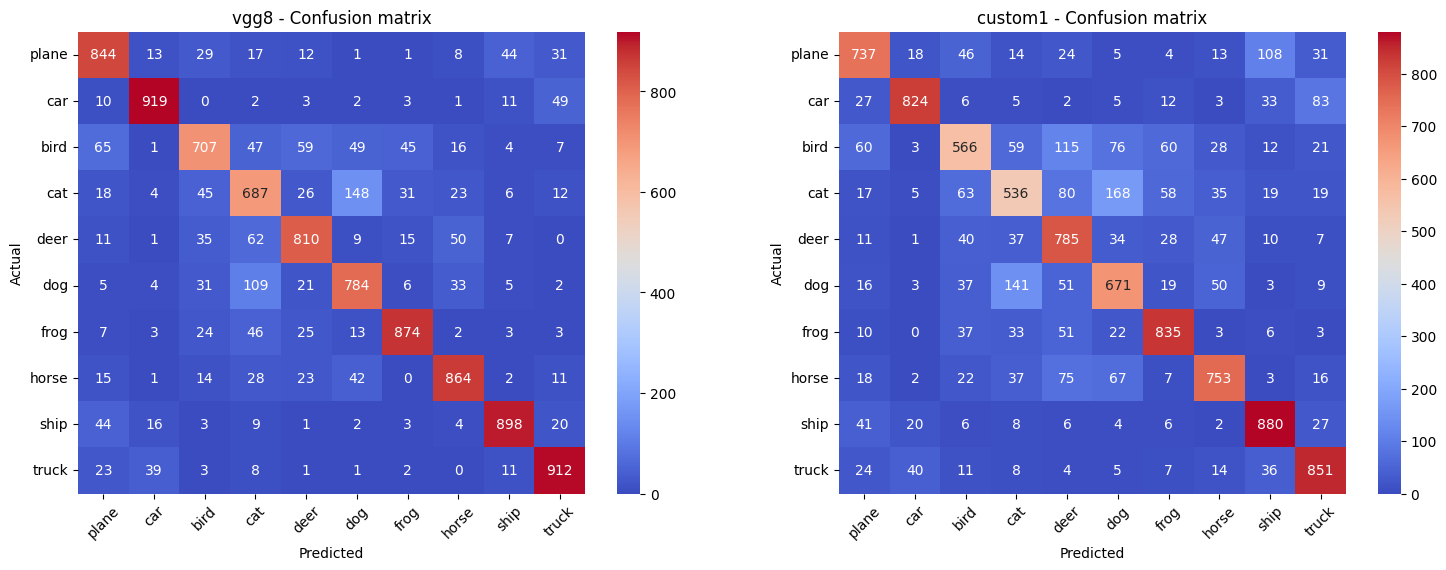

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1       vgg8  cifar10_0816_cnt_2000.ipynb        1672906      1019.2   
2    custom1  cifar10_0816_cnt_2000.ipynb          73738       447.3   
3     lenet1  cifar10_0816_cnt_2000.ipynb          83170       343.7   
4       mlp1  cifar10_0816_cnt_2000.ipynb         394634       228.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 10:31      0.0003     1.2263          1.0000         0.8299   
2  2022-08-16 10:14      0.2368     0.8096          0.9258         0.7438   
3  2022-08-16 10:06      0.3276     0.9998          0.8982         0.6736   
4  2022-08-16 10:00      1.4991     1.6743          0.4681         0.4116   

   train_auc  test_auc  
1     1.0000    0.9791  
2     0.9967    0.9651  
3     0.9944    0.9460  
4     0.8672    0.8291

In [28]:
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Resnet

see https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

2022-08-16 10:31:42,894: INFO: learning_rate=0.001
2022-08-16 10:31:42,896: INFO: model_params.resnet_v1_20.clip_value=None
2022-08-16 10:31:42,903: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 rescaling (Rescaling)          (None, 32, 32, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['rescaling[4][0]']              
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                          

                                                                                                  
 conv2d_15 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_8[0][0]']           
                                                                                                  
 batch_normalization_14 (BatchN  (None, 16, 16, 32)  128         ['conv2d_15[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_9 (Activation)      (None, 16, 16, 32)   0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 conv2d_16 (Conv2D)             (None, 16, 16, 32)   9248        ['activation_9[0][0]']           
                                                                                                  
 batch_nor

 add_8 (Add)                    (None, 8, 8, 64)     0           ['activation_16[0][0]',          
                                                                  'batch_normalization_23[0][0]'] 
                                                                                                  
 activation_18 (Activation)     (None, 8, 8, 64)     0           ['add_8[0][0]']                  
                                                                                                  
 average_pooling2d (AveragePool  (None, 1, 1, 64)    0           ['activation_18[0][0]']          
 ing2D)                                                                                           
                                                                                                  
 flatten_4 (Flatten)            (None, 64)           0           ['average_pooling2d[0][0]']      
                                                                                                  
 dense_9 (

2022-08-16 10:31:43,036: INFO: model_params.resnet_v1_20.epochs=90
2022-08-16 10:31:43,037: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20, monitor=val_accuracy)
2022-08-16 10:31:43,038: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2022-08-16 10:31:43,038: INFO: use LearningRateScheduler()
2022-08-16 10:31:43,039: INFO: steps_per_epoch=625
2022-08-16 10:31:43,040: INFO: start training
2022-08-16 10:31:43,040: INFO: use_class_weight=False


Epoch 1/90
623/625 [============================>.] - ETA: 0s - loss: 1.7312 - accuracy: 0.4280

2022-08-16 10:32:08,431: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:32:11,570: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 29s 40ms/step - loss: 1.7306 - accuracy: 0.4283 - val_loss: 2.1508 - val_accuracy: 0.3509 - lr: 0.0010
Epoch 2/90
625/625 [==============================] - ETA: 0s - loss: 1.3288 - accuracy: 0.5810

2022-08-16 10:32:32,465: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:32:35,418: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 24s 38ms/step - loss: 1.3288 - accuracy: 0.5810 - val_loss: 2.3099 - val_accuracy: 0.3772 - lr: 0.0010
Epoch 3/90
623/625 [============================>.] - ETA: 0s - loss: 1.1315 - accuracy: 0.6565

2022-08-16 10:32:56,464: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:32:59,810: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 24s 39ms/step - loss: 1.1318 - accuracy: 0.6562 - val_loss: 2.0047 - val_accuracy: 0.4632 - lr: 0.0010
Epoch 4/90
625/625 [==============================] - 13s 21ms/step - loss: 0.9871 - accuracy: 0.7119 - val_loss: 2.8344 - val_accuracy: 0.4002 - lr: 0.0010
Epoch 5/90
625/625 [==============================] - 13s 22ms/step - loss: 0.8680 - accuracy: 0.7552 - val_loss: 2.7121 - val_accuracy: 0.4456 - lr: 0.0010
Epoch 6/90
625/625 [==============================] - 14s 22ms/step - loss: 0.7709 - accuracy: 0.7955 - val_loss: 2.8981 - val_accuracy: 0.4366 - lr: 0.0010
Epoch 7/90
625/625 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.8303

2022-08-16 10:34:01,524: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:34:04,580: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 24s 38ms/step - loss: 0.6751 - accuracy: 0.8303 - val_loss: 2.8784 - val_accuracy: 0.4633 - lr: 0.0010
Epoch 8/90
625/625 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.8589

2022-08-16 10:34:25,415: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:34:28,511: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 24s 38ms/step - loss: 0.6131 - accuracy: 0.8589 - val_loss: 2.4416 - val_accuracy: 0.5199 - lr: 0.0010
Epoch 9/90
625/625 [==============================] - ETA: 0s - loss: 0.5583 - accuracy: 0.8798

2022-08-16 10:34:49,701: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:34:53,021: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 24s 39ms/step - loss: 0.5583 - accuracy: 0.8798 - val_loss: 1.7324 - val_accuracy: 0.6071 - lr: 0.0010
Epoch 10/90
625/625 [==============================] - 13s 22ms/step - loss: 0.5099 - accuracy: 0.8993 - val_loss: 3.1192 - val_accuracy: 0.4755 - lr: 0.0010
Epoch 11/90
625/625 [==============================] - 14s 22ms/step - loss: 0.4809 - accuracy: 0.9110 - val_loss: 2.2447 - val_accuracy: 0.5711 - lr: 0.0010
Epoch 12/90
625/625 [==============================] - 14s 22ms/step - loss: 0.4651 - accuracy: 0.9178 - val_loss: 2.6856 - val_accuracy: 0.5470 - lr: 0.0010
Epoch 13/90
625/625 [==============================] - 14s 22ms/step - loss: 0.4306 - accuracy: 0.9359 - val_loss: 2.7760 - val_accuracy: 0.5583 - lr: 0.0010
Epoch 14/90
625/625 [==============================] - ETA: 0s - loss: 0.4364 - accuracy: 0.9320

2022-08-16 10:36:09,382: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:36:12,518: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 25s 39ms/step - loss: 0.4364 - accuracy: 0.9320 - val_loss: 1.9972 - val_accuracy: 0.6355 - lr: 0.0010
Epoch 15/90
625/625 [==============================] - 14s 22ms/step - loss: 0.4294 - accuracy: 0.9352 - val_loss: 2.5635 - val_accuracy: 0.5762 - lr: 0.0010
Epoch 16/90
625/625 [==============================] - 14s 22ms/step - loss: 0.4026 - accuracy: 0.9470 - val_loss: 3.3776 - val_accuracy: 0.5144 - lr: 0.0010
Epoch 17/90
625/625 [==============================] - 14s 22ms/step - loss: 0.4075 - accuracy: 0.9475 - val_loss: 2.4644 - val_accuracy: 0.5715 - lr: 0.0010
Epoch 18/90
625/625 [==============================] - 14s 22ms/step - loss: 0.4162 - accuracy: 0.9444 - val_loss: 2.4327 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 19/90
625/625 [==============================] - 14s 22ms/step - loss: 0.3925 - accuracy: 0.9542 - val_loss: 2.2841 - val_accuracy: 0.6199 - lr: 0.0010
Epoch 20/90
625/625 [==============================] - 14s 22ms/

2022-08-16 10:38:23,545: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:38:26,548: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 23s 37ms/step - loss: 0.3945 - accuracy: 0.9578 - val_loss: 2.0096 - val_accuracy: 0.6527 - lr: 0.0010
Epoch 24/90
623/625 [============================>.] - ETA: 0s - loss: 0.3953 - accuracy: 0.9577
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
625/625 [==============================] - 17s 28ms/step - loss: 0.3953 - accuracy: 0.9576 - val_loss: 2.6700 - val_accuracy: 0.6101 - lr: 3.1623e-04
Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/90
625/625 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.9827

2022-08-16 10:39:09,794: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:39:13,021: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 29s 47ms/step - loss: 0.3283 - accuracy: 0.9827 - val_loss: 1.7994 - val_accuracy: 0.6941 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/90
624/625 [============================>.] - ETA: 0s - loss: 0.2812 - accuracy: 0.9991

2022-08-16 10:39:37,310: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:39:40,819: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 28s 45ms/step - loss: 0.2812 - accuracy: 0.9991 - val_loss: 1.7809 - val_accuracy: 0.7017 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/90
625/625 [==============================] - 16s 26ms/step - loss: 0.2675 - accuracy: 1.0000 - val_loss: 1.8091 - val_accuracy: 0.7007 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/90
625/625 [==============================] - 18s 30ms/step - loss: 0.2572 - accuracy: 1.0000 - val_loss: 1.8289 - val_accuracy: 0.7017 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/90
625/625 [==============================] - 17s 28ms/step - loss: 0.2454 - accuracy: 1.0000 - val_loss: 1.8473 - val_accuracy: 0.7017 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/90
625/625 [==============================] - 16s 26ms/step - loss: 0.2311 - accuracy: 1.0000 -

2022-08-16 10:41:14,602: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:41:17,654: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 29s 46ms/step - loss: 0.2138 - accuracy: 1.0000 - val_loss: 1.8724 - val_accuracy: 0.7018 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/90
625/625 [==============================] - 18s 29ms/step - loss: 0.1935 - accuracy: 1.0000 - val_loss: 1.8789 - val_accuracy: 0.7014 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/90
625/625 [==============================] - 18s 30ms/step - loss: 0.1704 - accuracy: 1.0000 - val_loss: 1.8802 - val_accuracy: 0.6994 - lr: 3.1623e-04
Epoch 00034: Still keep learning rate 0.0003162 instead of 0.001
Epoch 34/90
625/625 [==============================] - 16s 26ms/step - loss: 0.1450 - accuracy: 1.0000 - val_loss: 1.8785 - val_accuracy: 0.6973 - lr: 3.1623e-04
Epoch 00035: Still keep learning rate 0.0003162 instead of 0.001
Epoch 35/90
625/625 [==============================] - 19s 30ms/step - loss: 0.2380 - accuracy: 0.9629 -

2022-08-16 10:50:26,296: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 21). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


2022-08-16 10:50:29,331: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20/assets


625/625 [==============================] - 29s 47ms/step - loss: 0.2256 - accuracy: 0.9672 - val_loss: 1.4189 - val_accuracy: 0.7138 - lr: 1.0000e-04
Epoch 62/90
625/625 [==============================] - 18s 29ms/step - loss: 0.1531 - accuracy: 0.9958 - val_loss: 1.4731 - val_accuracy: 0.7134 - lr: 1.0000e-04
Epoch 63/90
625/625 [==============================] - 19s 30ms/step - loss: 0.1381 - accuracy: 0.9997 - val_loss: 1.5383 - val_accuracy: 0.7120 - lr: 1.0000e-04
Epoch 64/90
625/625 [==============================] - 18s 30ms/step - loss: 0.1323 - accuracy: 1.0000 - val_loss: 1.5939 - val_accuracy: 0.7132 - lr: 1.0000e-04
Epoch 65/90
625/625 [==============================] - 18s 30ms/step - loss: 0.1288 - accuracy: 1.0000 - val_loss: 1.6428 - val_accuracy: 0.7127 - lr: 1.0000e-04
Epoch 66/90
625/625 [==============================] - 18s 29ms/step - loss: 0.1258 - accuracy: 1.0000 - val_loss: 1.6880 - val_accuracy: 0.7128 - lr: 1.0000e-04
Epoch 67/90
625/625 [===================

2022-08-16 10:59:20,654: INFO: finish training [elapsed time: 1657.61 seconds]


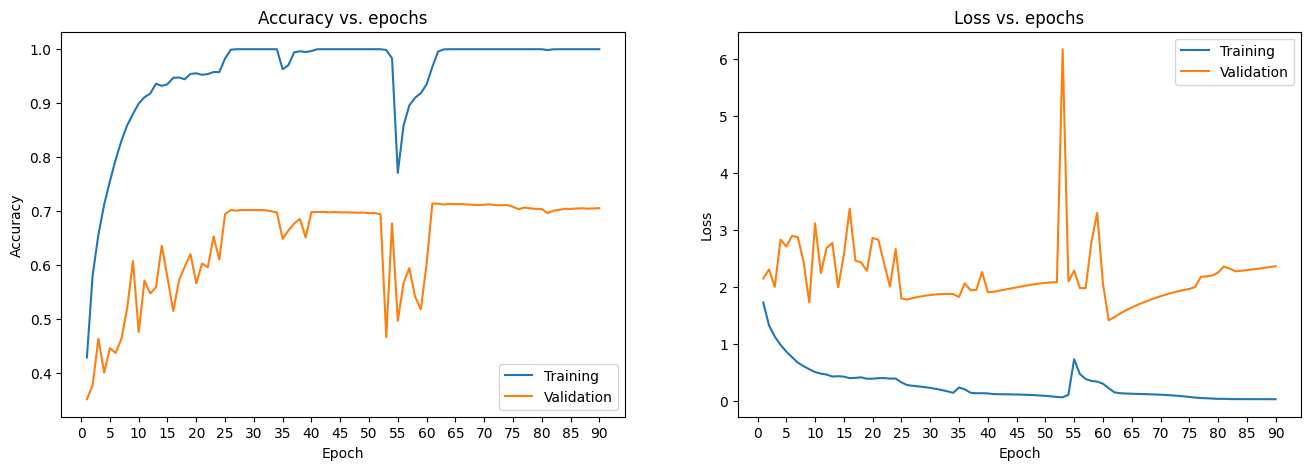

2022-08-16 10:59:21,078: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/resnet_v1_20
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 2s 6ms/step


2022-08-16 10:59:41,322: INFO: test loss:1.4189
2022-08-16 10:59:41,323: INFO: test accuracy:0.7138
2022-08-16 10:59:41,327: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 10:59:41,328: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 10:59:41,329: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 10:59:41,330: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 10:59:41,331: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 10:59:42,978: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator


313/313 [==============================] - 1s 4ms/step


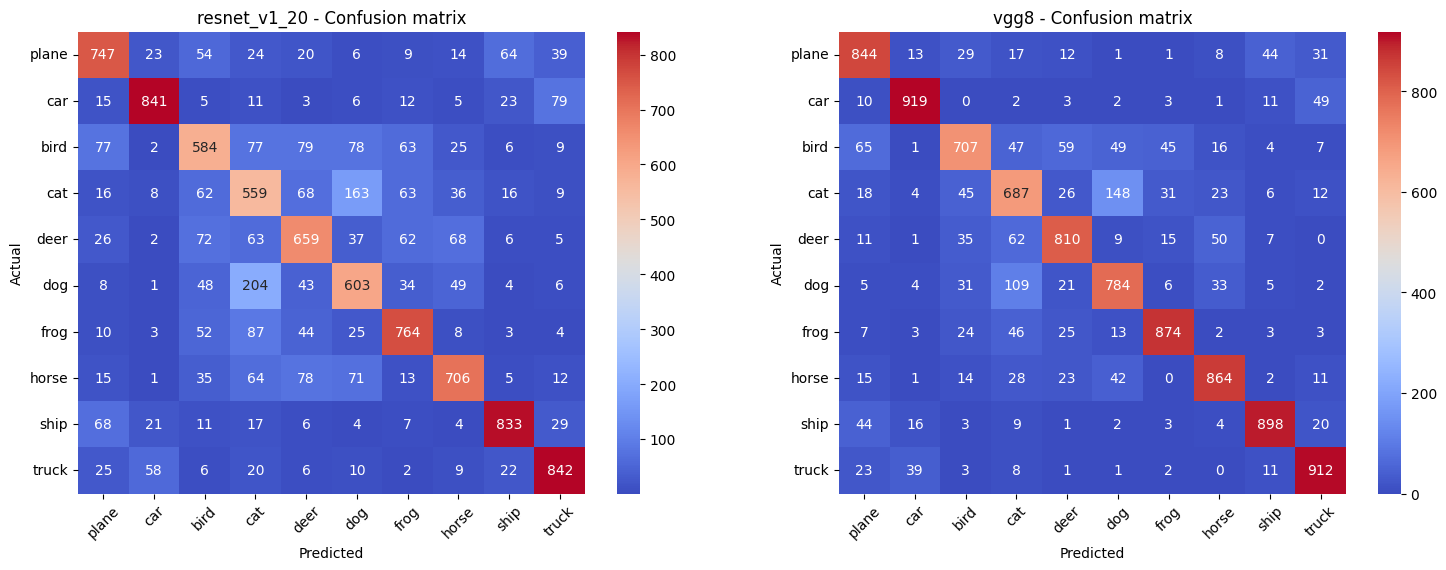

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  train_time  \
1          vgg8  cifar10_0816_cnt_2000.ipynb        1672906      1019.2   
2       custom1  cifar10_0816_cnt_2000.ipynb          73738       447.3   
3  resnet_v1_20  cifar10_0816_cnt_2000.ipynb         273066      1657.6   
4        lenet1  cifar10_0816_cnt_2000.ipynb          83170       343.7   
5          mlp1  cifar10_0816_cnt_2000.ipynb         394634       228.7   

        create_time  train_loss  test_loss  train_accuracy  test_accuracy  \
1  2022-08-16 10:31      0.0003     1.2263          1.0000         0.8299   
2  2022-08-16 10:14      0.2368     0.8096          0.9258         0.7438   
3  2022-08-16 10:59      0.1711     1.4189          0.9879         0.7138   
4  2022-08-16 10:06      0.3276     0.9998          0.8982         0.6736   
5  2022-08-16 10:00      1.4991     1.6743          0.4681         0.4116   

   train_auc  test_auc  
1     1.0000    0.9791  
2     0.9967    0.9651  
3     0.9999    0.9546  
4     0.9944    0.9460  
5     0.8672    0.8291

In [29]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20, preprocess_fun=rescale)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=False) 

### Pretrained Model + Fune-Tune

In [30]:
class ResizeLayer(tf.keras.layers.Layer):
    def __init__(self, shape):
        super(ResizeLayer, self).__init__()
        self.shape = shape

    def call(self, inputs, training=False):
#         print(type(inputs))
#         return tf.convert_to_tensor(resize_images(inputs.numpy(), self.shape))
        return tf.image.resize(inputs, self.shape)

In [31]:
rescale1 = tf.keras.layers.Rescaling(1./127.5, offset=-1)
input_shape = [160, 160, 3]

In [32]:
preprocess_fun =  [ResizeLayer(input_shape[:-1]), rescale1]

(32, 160, 160, 3) <class 'tensorflow.python.framework.ops.EagerTensor'>


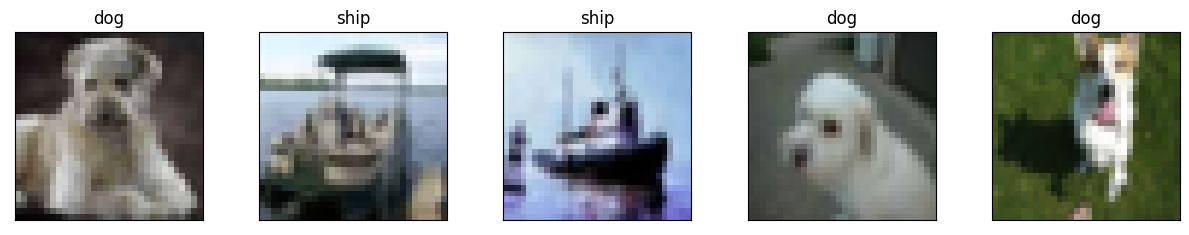

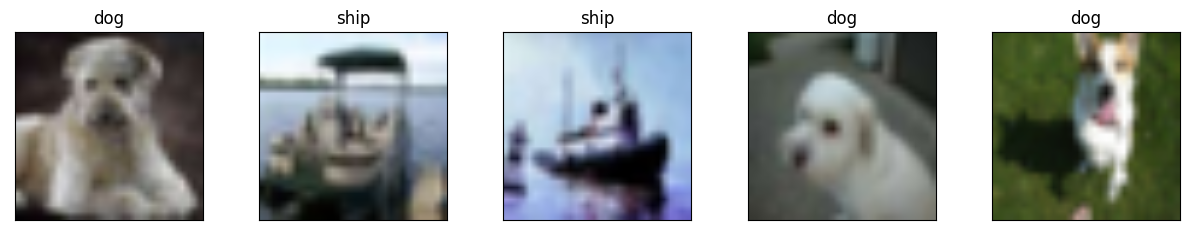

In [33]:
sample_images1 = ResizeLayer(input_shape[:-1])(sample_images)
print(sample_images1.shape, type(sample_images1)) 
qtf.utils.show_images(sample_images.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))
qtf.utils.show_images(sample_images1.numpy(), sample_labels, classes=params.classes, x_num=1, y_num=5, figsize=(12, 3))

#### MobileNet V2

In [34]:
base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_6[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [35]:
def pretrained_model(helper, base_model, dropout=None, name='pretrained_model', last_activation=None, preprocess_fun=None):
    if dropout is None:
        dropout = helper.params.get_model_param(name, 'dropout')

    input_shape = qbz95.tf.classification.get_input_shape(helper.datasets.train_dataset)
    input = layers.Input(shape=input_shape)
    x = qbz95.tf.classification.image_models.process_funs(input, preprocess_fun)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    if dropout > 0: x = layers.Dropout(dropout)(x)
    x = helper.get_dense_layer(len(helper.params.classes), activation=last_activation)(x)

    model = Model(inputs=input, outputs=x, name=name)
    helper.compile(model)
    return model

def fine_tuning(helper, model, base_model, fine_tune_at, learning_rate=0.00001):
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=helper.params.metrics)
    return model 

In [36]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = pretrained_model(helper, base_model, dropout=0.2, name='pretrained-MobileNetV2', preprocess_fun=preprocess_fun)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')
model.summary()

loss0, accuracy0 = model.evaluate(datasets.test_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

2022-08-16 10:59:52,176: INFO: model_params.pretrained-MobileNetV2.learning_rate=0.0001
2022-08-16 10:59:52,177: INFO: model_params.pretrained-MobileNetV2.clip_value=None
2022-08-16 10:59:52,185: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2


len(model.trainable_variables)=2
Model: "pretrained-MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resize_layer (ResizeLayer)  (None, 160, 160, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_10

2022-08-16 11:00:03,914: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-16 11:00:03,915: INFO: steps_per_epoch=625
2022-08-16 11:00:03,916: INFO: start training
2022-08-16 11:00:03,916: INFO: use_class_weight=False


Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 1.6126 - accuracy: 0.4628

2022-08-16 11:00:50,944: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:00:55,888: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 53s 80ms/step - loss: 1.6126 - accuracy: 0.4628 - val_loss: 0.8409 - val_accuracy: 0.7409
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.8014 - accuracy: 0.7347

2022-08-16 11:01:40,825: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:01:45,899: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 50s 80ms/step - loss: 0.8014 - accuracy: 0.7347 - val_loss: 0.6295 - val_accuracy: 0.7950
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.7817

2022-08-16 11:02:31,007: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:02:35,783: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 50s 80ms/step - loss: 0.6471 - accuracy: 0.7817 - val_loss: 0.5559 - val_accuracy: 0.8162
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.5840 - accuracy: 0.8002

2022-08-16 11:03:20,775: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:03:25,799: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 50s 80ms/step - loss: 0.5840 - accuracy: 0.8002 - val_loss: 0.5169 - val_accuracy: 0.8265
Epoch 5/10
625/625 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.8169

2022-08-16 11:04:10,947: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:04:15,957: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 50s 80ms/step - loss: 0.5383 - accuracy: 0.8169 - val_loss: 0.4924 - val_accuracy: 0.8342
Epoch 6/10
625/625 [==============================] - ETA: 0s - loss: 0.5099 - accuracy: 0.8257

2022-08-16 11:05:01,187: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:05:06,299: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 50s 81ms/step - loss: 0.5099 - accuracy: 0.8257 - val_loss: 0.4753 - val_accuracy: 0.8410
Epoch 7/10
625/625 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.8328

2022-08-16 11:05:51,351: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:05:56,093: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 50s 80ms/step - loss: 0.4857 - accuracy: 0.8328 - val_loss: 0.4639 - val_accuracy: 0.8430
Epoch 8/10
625/625 [==============================] - ETA: 0s - loss: 0.4632 - accuracy: 0.8413

2022-08-16 11:06:41,614: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:06:46,325: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 50s 80ms/step - loss: 0.4632 - accuracy: 0.8413 - val_loss: 0.4552 - val_accuracy: 0.8459
Epoch 9/10
625/625 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.8458

2022-08-16 11:07:31,415: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:07:36,454: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 50s 80ms/step - loss: 0.4475 - accuracy: 0.8458 - val_loss: 0.4476 - val_accuracy: 0.8478
Epoch 10/10
625/625 [==============================] - ETA: 0s - loss: 0.4380 - accuracy: 0.8493

2022-08-16 11:08:21,452: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:08:26,126: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 50s 80ms/step - loss: 0.4380 - accuracy: 0.8493 - val_loss: 0.4410 - val_accuracy: 0.8509


2022-08-16 11:08:26,889: INFO: finish training [elapsed time: 502.97 seconds]


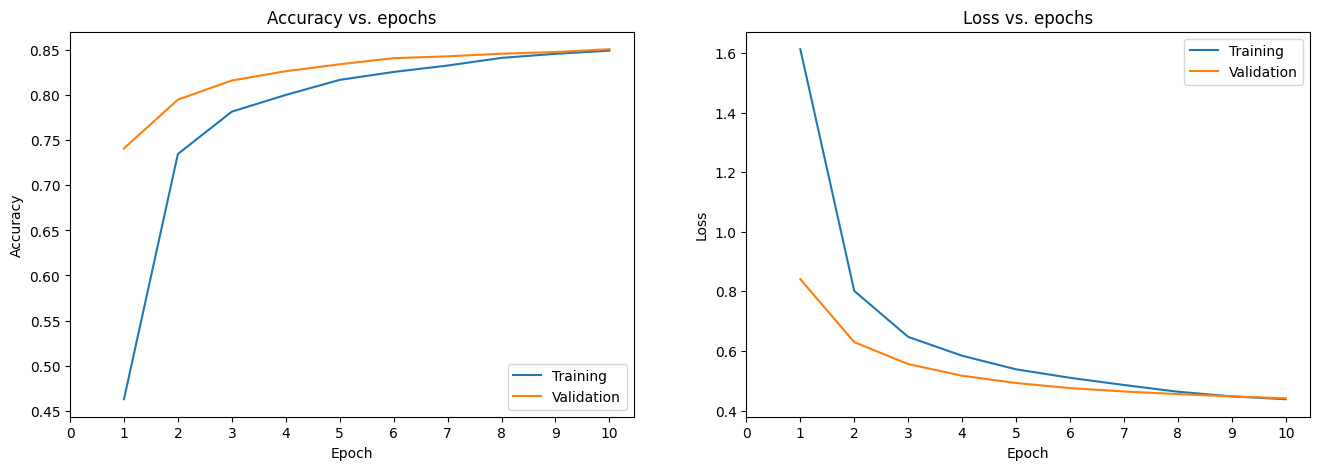

In [37]:
history = helper.train(model, epochs=10, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))

In [38]:
model = fine_tuning(helper, model, base_model, fine_tune_at=100, learning_rate=0.00001)
print(f'len(model.trainable_variables)={len(model.trainable_variables)}')

len(model.trainable_variables)=56


2022-08-16 11:08:28,265: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2, monitor=val_accuracy)
2022-08-16 11:08:28,265: INFO: steps_per_epoch=625
2022-08-16 11:08:28,266: INFO: start training
2022-08-16 11:08:28,267: INFO: use_class_weight=False


Epoch 1/15
625/625 [==============================] - ETA: 0s - loss: 0.3946 - accuracy: 0.8652

2022-08-16 11:09:31,262: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:09:36,212: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 69s 101ms/step - loss: 0.3946 - accuracy: 0.8652 - val_loss: 0.3720 - val_accuracy: 0.8721
Epoch 2/15
625/625 [==============================] - ETA: 0s - loss: 0.3052 - accuracy: 0.8956

2022-08-16 11:10:34,165: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:10:39,165: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 63s 101ms/step - loss: 0.3052 - accuracy: 0.8956 - val_loss: 0.3401 - val_accuracy: 0.8866
Epoch 3/15
625/625 [==============================] - ETA: 0s - loss: 0.2521 - accuracy: 0.9128

2022-08-16 11:11:37,260: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:11:42,268: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 63s 101ms/step - loss: 0.2521 - accuracy: 0.9128 - val_loss: 0.3270 - val_accuracy: 0.8927
Epoch 4/15
624/625 [============================>.] - ETA: 0s - loss: 0.2029 - accuracy: 0.9305

2022-08-16 11:12:40,458: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:12:45,424: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 63s 101ms/step - loss: 0.2031 - accuracy: 0.9305 - val_loss: 0.3185 - val_accuracy: 0.8948
Epoch 5/15
625/625 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9407

2022-08-16 11:13:43,625: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:13:48,680: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 63s 101ms/step - loss: 0.1668 - accuracy: 0.9407 - val_loss: 0.3255 - val_accuracy: 0.8951
Epoch 6/15
624/625 [============================>.] - ETA: 0s - loss: 0.1349 - accuracy: 0.9549

2022-08-16 11:14:38,807: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:14:44,113: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 55s 89ms/step - loss: 0.1351 - accuracy: 0.9549 - val_loss: 0.3261 - val_accuracy: 0.8976
Epoch 7/15
625/625 [==============================] - ETA: 0s - loss: 0.1069 - accuracy: 0.9645

2022-08-16 11:15:32,556: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:15:37,970: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 54s 86ms/step - loss: 0.1069 - accuracy: 0.9645 - val_loss: 0.3325 - val_accuracy: 0.8991
Epoch 8/15
625/625 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9736

2022-08-16 11:16:28,493: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:16:33,430: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 55s 89ms/step - loss: 0.0868 - accuracy: 0.9736 - val_loss: 0.3343 - val_accuracy: 0.9010
Epoch 9/15
625/625 [==============================] - 33s 53ms/step - loss: 0.0690 - accuracy: 0.9787 - val_loss: 0.3602 - val_accuracy: 0.8981
Epoch 10/15
625/625 [==============================] - 32s 52ms/step - loss: 0.0532 - accuracy: 0.9836 - val_loss: 0.3601 - val_accuracy: 0.9004
Epoch 11/15
625/625 [==============================] - 32s 51ms/step - loss: 0.0412 - accuracy: 0.9885 - val_loss: 0.3891 - val_accuracy: 0.8988
Epoch 12/15
625/625 [==============================] - 33s 53ms/step - loss: 0.0320 - accuracy: 0.9916 - val_loss: 0.4071 - val_accuracy: 0.8969
Epoch 13/15
625/625 [==============================] - 34s 54ms/step - loss: 0.0263 - accuracy: 0.9929 - val_loss: 0.4194 - val_accuracy: 0.8985
Epoch 14/15
625/625 [==============================] - ETA: 0s - loss: 0.0179 - accuracy: 0.9961

2022-08-16 11:20:08,744: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:20:14,091: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 56s 89ms/step - loss: 0.0179 - accuracy: 0.9961 - val_loss: 0.4151 - val_accuracy: 0.9027
Epoch 15/15
625/625 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9972

2022-08-16 11:21:04,768: WARNING: Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 5 of 52). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


2022-08-16 11:21:09,770: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2/assets


625/625 [==============================] - 56s 89ms/step - loss: 0.0147 - accuracy: 0.9972 - val_loss: 0.4282 - val_accuracy: 0.9058


2022-08-16 11:21:10,561: INFO: finish training [elapsed time: 762.30 seconds]


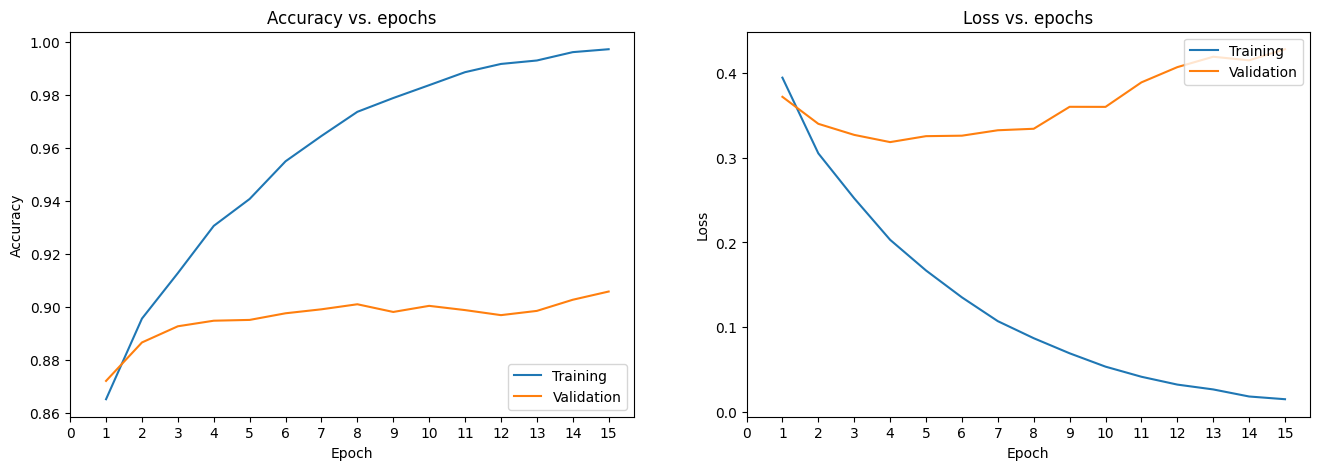

2022-08-16 11:21:10,970: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2
----------------------------------------evaluate----------------------------------------
313/313 [==============================] - 8s 24ms/step


2022-08-16 11:22:12,488: INFO: test loss:0.4282
2022-08-16 11:22:12,489: INFO: test accuracy:0.9058
2022-08-16 11:22:12,493: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 11:22:12,495: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/results.json
2022-08-16 11:22:12,495: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 11:22:12,497: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 11:22:12,497: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/vgg8


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2022-08-16 11:22:14,040: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator


313/313 [==============================] - 1s 3ms/step


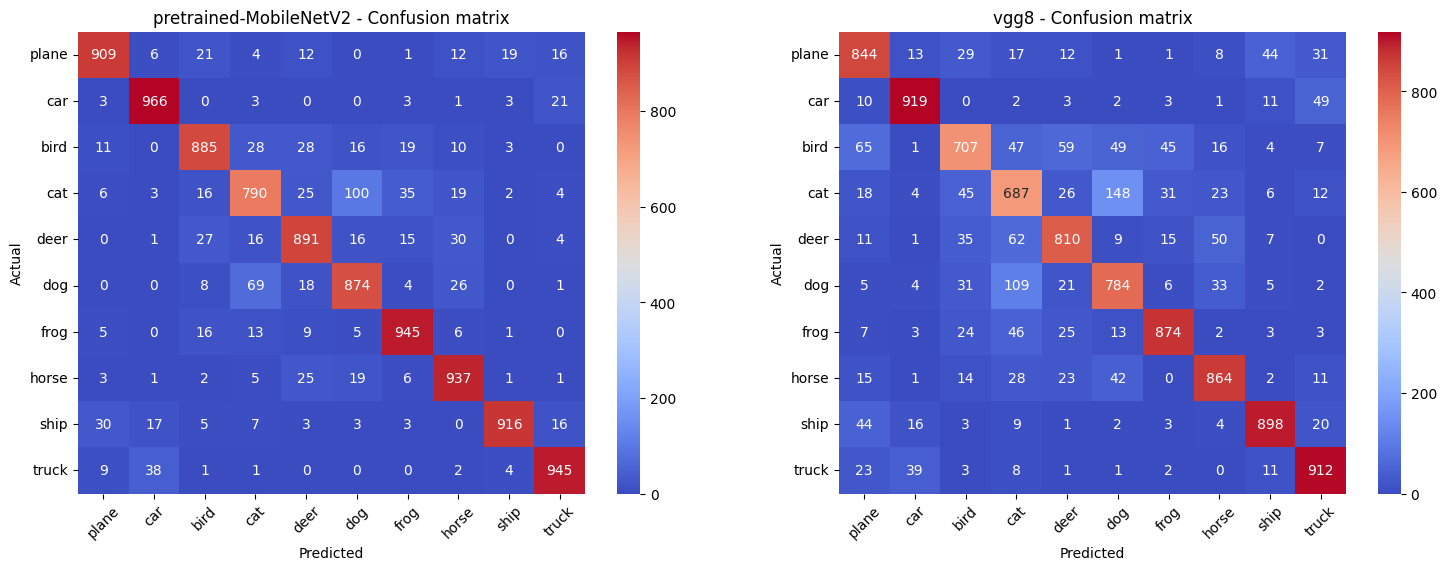

----------------------------------------models----------------------------------------


model_name                 program_name  weight_number  \
1  pretrained-MobileNetV2  cifar10_0816_cnt_2000.ipynb        1874250   
2                    vgg8  cifar10_0816_cnt_2000.ipynb        1672906   
3                 custom1  cifar10_0816_cnt_2000.ipynb          73738   
4            resnet_v1_20  cifar10_0816_cnt_2000.ipynb         273066   
5                  lenet1  cifar10_0816_cnt_2000.ipynb          83170   
6                    mlp1  cifar10_0816_cnt_2000.ipynb         394634   

   train_time       create_time  train_loss  test_loss  train_accuracy  \
1       762.3  2022-08-16 11:22      0.0112     0.4282          0.9976   
2      1019.2  2022-08-16 10:31      0.0003     1.2263          1.0000   
3       447.3  2022-08-16 10:14      0.2368     0.8096          0.9258   
4      1657.6  2022-08-16 10:59      0.1711     1.4189          0.9879   
5       343.7  2022-08-16 10:06      0.3276     0.9998          0.8982   
6       228.7  2022-08-16 10:00      1.4991     1.6743          0.4681   

   test_accuracy  train_auc  test_auc  
1         0.9058     1.0000    0.9944  
2         0.8299     1.0000    0.9791  
3         0.7438     0.9967    0.9651  
4         0.7138     0.9999    0.9546  
5         0.6736     0.9944    0.9460  
6         0.4116     0.8672    0.8291

In [39]:
history = helper.train(model, epochs=15, callbacks=helper.get_callbacks(model, params.pretrained_callbacks))
helper.model_summary(model, history, show_sample_analysis=False) 

## Evaluation

### Best Model

In [40]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2022-08-16 11:22:24,997: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2022-08-16 11:22:24,999: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/results.json
2022-08-16 11:22:25,000: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_500/results.json
2022-08-16 11:22:25,001: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_200/results.json
2022-08-16 11:22:25,002: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_100/results.json
2022-08-16 11:22:25,004: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/ima

model_name                 program_name  weight_number  \
1   pretrained-MobileNetV2  cifar10_0816_cnt_2000.ipynb        1874250   
2   pretrained-MobileNetV2  cifar10_0816_cnt_1000.ipynb        1874250   
3                     vgg8  cifar10_0816_cnt_5000.ipynb        1672906   
4   pretrained-MobileNetV2   cifar10_0816_cnt_500.ipynb        1874250   
5   pretrained-MobileNetV2   cifar10_0816_cnt_200.ipynb        1874250   
6                     vgg8  cifar10_0816_cnt_2000.ipynb        1672906   
7   pretrained-MobileNetV2   cifar10_0816_cnt_100.ipynb        1874250   
8                  custom1  cifar10_0816_cnt_5000.ipynb          73738   
9                     vgg8  cifar10_0816_cnt_1000.ipynb        1672906   
10  pretrained-MobileNetV2    cifar10_0816_cnt_50.ipynb        1874250   

    train_time       create_time  train_loss  test_loss  train_accuracy  \
1        762.3  2022-08-16 11:22      0.0112     0.4282          0.9976   
2        598.4  2022-08-16 09:26      0.0212     0.4112          0.9963   
3       2113.1  2022-08-16 11:13      0.0005     0.8218          0.9999   
4        487.0  2022-08-16 09:53      0.0125     0.4696          0.9992   
5        427.4  2022-08-16 09:54      0.0315     0.5364          0.9960   
6       1019.2  2022-08-16 10:31      0.0003     1.2263          1.0000   
7        399.4  2022-08-16 09:37      0.0413     0.6508          0.9950   
8       1118.6  2022-08-16 10:38      0.3380     0.6129          0.8843   
9        435.9  2022-08-16 08:46      0.0137     1.3588          0.9992   
10       468.0  2022-08-16 10:25      0.0734     0.7535          0.9940   

    test_accuracy  train_auc  test_auc  
1          0.9058     1.0000    0.9944  
2          0.8930     1.0000    0.9929  
3          0.8845     1.0000    0.9893  
4          0.8778     1.0000    0.9906  
5          0.8412     1.0000    0.9857  
6          0.8299     1.0000    0.9791  
7          0.8021     0.9999    0.9788  
8          0.7911     0.9930    0.9776  
9          0.7527     1.0000    0.9586  
10         0.7487     1.0000    0.9661

In [41]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2022-08-16 11:22:25,081: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/pretrained-MobileNetV2
2022-08-16 11:22:35,284: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_2000/default.generator
2022-08-16 11:22:35,304: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/pretrained-MobileNetV2
2022-08-16 11:22:46,688: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_1000/default.generator
2022-08-16 11:22:46,691: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0816_cnt_5000/vgg8
2022-08-16 11:22:48,261: INFO: loading generator from /tf/eipi10/xuxia

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


None

In [42]:
predictors[0].classes

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

1/1 [==============================] - 0s 237ms/step


2022-08-16 11:23:11,895: WARNING: 5 out of the last 317 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fbf06c04af0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 1s 892ms/step


2022-08-16 11:23:13,542: WARNING: 6 out of the last 318 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fbf06a541f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 0s 18ms/step


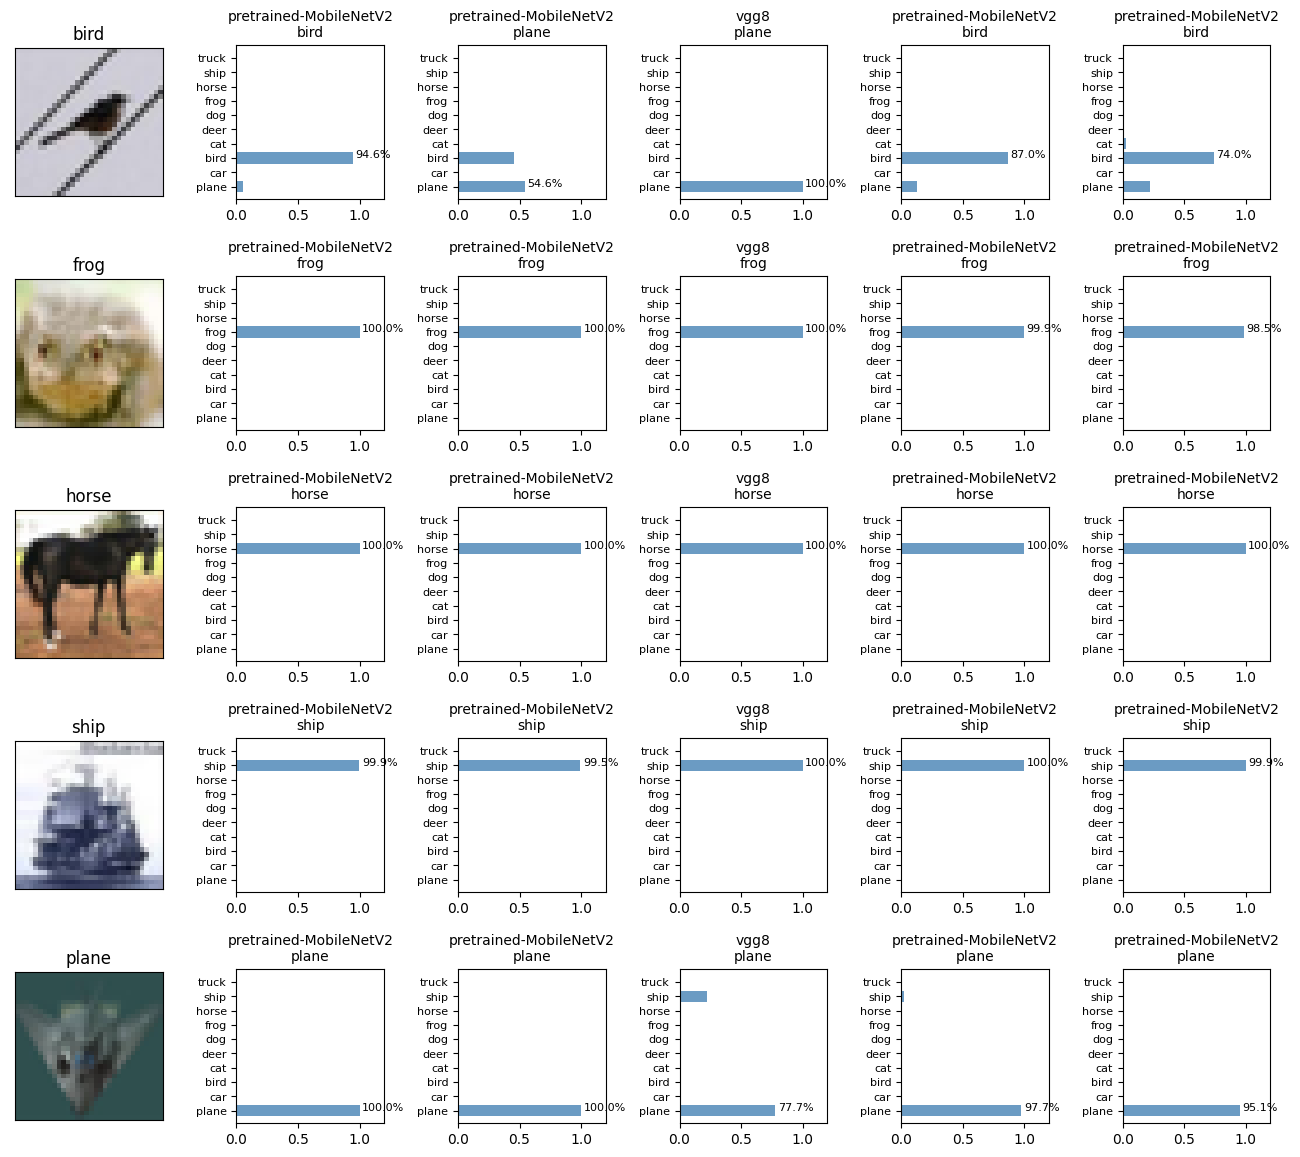

In [43]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                     sample_count=5, show_error_sample=False) 

1/1 [==============================] - 0s 18ms/step


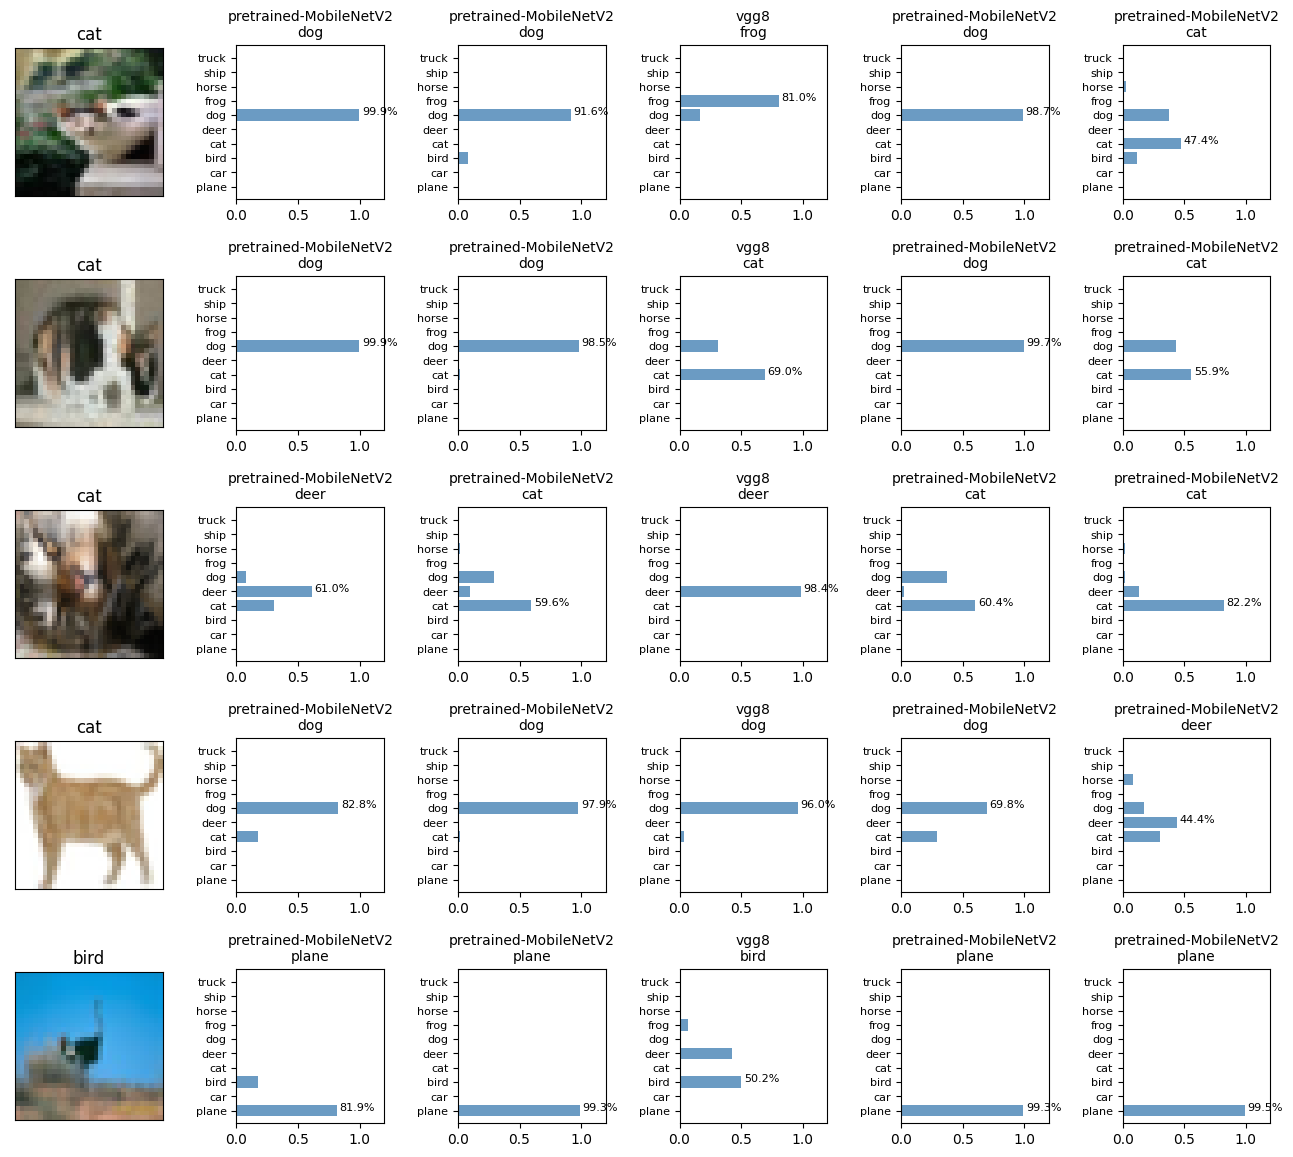

In [44]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### Evaluate

In [45]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.4282495975494385, 'accuracy': 0.9057999849319458, 'mae': 13.559281349182129}
313/313 [==============================] - 8s 25ms/step
(10000, 10)


In [46]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

313/313 [==============================] - 8s 24ms/step


precision  recall        f1
plane   0.931352   0.909  0.920040
car     0.936047   0.966  0.950787
bird    0.902141   0.885  0.893488
cat     0.844017   0.790  0.816116
deer    0.881306   0.891  0.886126
dog     0.846079   0.874  0.859813
frog    0.916586   0.945  0.930576
horse   0.898370   0.937  0.917279
ship    0.965227   0.916  0.939969
truck   0.937500   0.945  0.941235

----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9314    0.9090    0.9200      1000
         car     0.9360    0.9660    0.9508      1000
        bird     0.9021    0.8850    0.8935      1000
         cat     0.8440    0.7900    0.8161      1000
        deer     0.8813    0.8910    0.8861      1000
         dog     0.8461    0.8740    0.8598      1000
        frog     0.9166    0.9450    0.9306      1000
       horse     0.8984    0.9370    0.9173      1000
        ship     0.9652    0.9160    0.9400      1000
       truck     0.9375    0.9450    0.9412      1000

    accuracy                         0.9058     10000
   macro avg     0.9059    0.9058    0.9055     10000
weighted avg     0.9059    0.9058    0.9055     10000



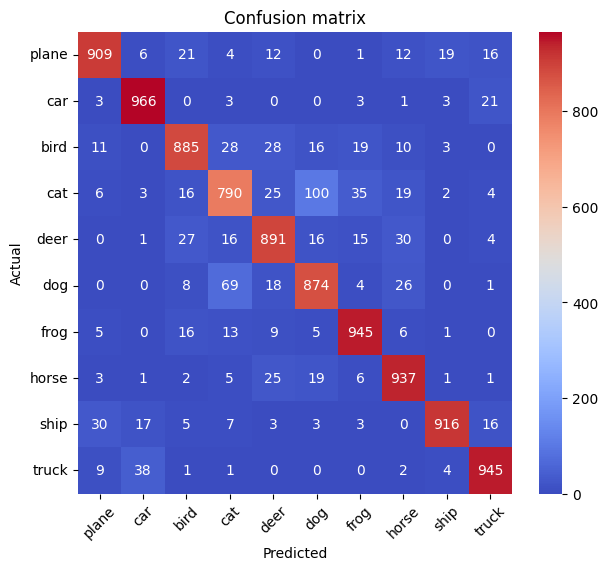

In [47]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## Reference

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)